In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import os
import shutil, sys                                                                                                                                                    
from collections import Counter

import re
from operator import itemgetter
from sklearn.cluster import AgglomerativeClustering
nltk.download('vader_lexicon')
from nltk import pos_tag, word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.cluster import KMeans
from gensim import corpora
from gensim.models import LsiModel, LdaModel
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from nltk.corpus import stopwords
from gensim.corpora.dictionary import Dictionary


def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        #model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model = LdaModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary,alpha="auto",eval_every=2)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean,start, stop, step, doc_term_matrix,dictionary):
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean, stop, start, step)
    # Show graph
    #print(coherence_values)
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    c = coherence_values.index(max(coherence_values))
    return start + c

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/menis/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/menis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/menis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/menis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/menis/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
data = pd.read_json("preprocessingDoneRight.json")
post = data[data["year"] >= 2016]
len(post)

10325

In [3]:
data.head()

,in_reply_to_user_id_str,is_retweet,text,month,year,hour,week_year,date,modded_text,modded1,noTags_punct,modded1_stemmed
0,NaN,False,Be sure to tune in and watch Donald Trump on L...,5,2009,18,19,2009-05-04,be sure to tune in and watch donald trump on l...,sure tune watch donald trump late night david ...,be sure to tune in and watch donald trump on l...,sure tune watch donald trump late night...
1,NaN,False,Donald Trump will be appearing on The View tom...,5,2009,1,19,2009-05-05,donald trump will be appearing on the view tom...,donald trump appearing view tomorrow morning d...,donald trump will be appearing on the view tom...,donald trump appear view tomorrow morn ...
10,NaN,False,"""Don’t be afraid of being unique - it's like b...",5,2009,15,20,2009-05-17,"""don’t be afraid of being unique - it's like b...",afraid unique like afraid best self donald j t...,don t be afraid of being unique its like bein...,afraid uniqu like afraid best self dona...
100,NaN,False,The latest update on Bret Michaels is that he'...,5,2010,16,20,2010-05-20,the latest update on bret michaels is that he'...,latest update bret michaels hes making every e...,the latest update on bret michaels is that hes...,latest updat bret michael he make everi...
1000,NaN,False,China is driving the price of gold up in order...,1,2012,19,1,2012-01-05,china is driving the price of gold up in order...,china driving price gold order ease pressure i...,china is driving the price of gold up in order...,china drive price gold order eas pressu...


In [4]:
def applyVader(data):
    vader = SentimentIntensityAnalyzer()
    text = data["text"].tolist()
    scores = list()
    positive = list()
    negative = list()
    neut = list()
    for t in text:
        scores.append(vader.polarity_scores(t)['compound'])
        positive.append(vader.polarity_scores(t)['pos'])
        negative.append(vader.polarity_scores(t)['neg'])
        neut.append(vader.polarity_scores(t)['neu'])
    data["vaderScore"] = scores
    data = data[data["is_retweet"] == False]
    data["vaderScoreBinned"] = pd.cut(data["vaderScore"], [-1,-0.05,0.05,1], labels=["negative", "neutral", "positive"])
    data.rename(index=str, columns={"year": "date_year"},inplace=True)
    data.rename(index=str, columns={"month": "date_month"},inplace=True)
    data.drop(["date_month","hour","in_reply_to_user_id_str","is_retweet","modded_text","modded1","date","week_year"],axis=1,inplace=True)
    data.corr()
    return data

def applyVader1(data):
    vader = SentimentIntensityAnalyzer()
    text = data["text"].tolist()
    scores = list()
    positive = list()
    negative = list()
    neut = list()
    for t in text:
        scores.append(vader.polarity_scores(t)['compound'])
        positive.append(vader.polarity_scores(t)['pos'])
        negative.append(vader.polarity_scores(t)['neg'])
        neut.append(vader.polarity_scores(t)['neu'])
    data["vaderScore"] = scores
    data["vaderScoreBinned"] = pd.cut(data["vaderScore"], [-1,-0.05,0.05,1], labels=["negative", "neutral", "positive"])
    data.rename(index=str, columns={"year": "date_year"},inplace=True)
    data.rename(index=str, columns={"month": "date_month"},inplace=True)
    data.drop(['Unnamed: 0','week_year', 'date_month',
       'modded_text', 'modded1','modded1_stemmed'],axis=1,inplace=True)
    data.corr()
    return data

In [5]:
def processAndFindTopics(data):
    stop = stopwords.words('english')
    data['temp'] = data['noTags_punct'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    words = pd.Series(' '.join(data['temp']).split()).value_counts()
    print(len(words))
    plt.title("pre word distribution")
    plt.hist(words.values,bins=70,log=True)
    plt.show()
    words = words[5:]
    words = words[words > 2]
    plt.title("post word distribution")
    plt.hist(words.values,bins=70,log=True)
    plt.show()
    data['temp'] = data['temp'].apply(lambda x: " ".join(x for x in x.split() if x in words))
    tokenizer = RegexpTokenizer(r'\w+')

    #corpus = d1["m"].tolist()
    corpus = data["temp"].tolist()
    #print(len(corpus))
    corp = []
    for string in corpus:
        tokens = tokenizer.tokenize(str(string))
        corp.append(tokens)

    common_dictionary = Dictionary(corp)
    common_corpus = [common_dictionary.doc2bow(text) for text in corp]
    #tfidf = TfidfModel(common_corpus)
    #tfidf_corpus = tfidf[common_corpus]
    start,stop,step=3,20,1
    nTopics = plot_graph(corp,start,stop,step,common_corpus,common_dictionary) #usare tfidf mi pare di aver capito sia inutile
                         #tfidf_corpus,common_dictionary)

    print(nTopics)
    return nTopics, common_dictionary, common_corpus

#cambia nome non è più tfidf corpus

In [6]:
def procAndTopicsTagged(data):
    stop = stopwords.words('english')
    data['temp'] = data['noTags_punct'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    words = pd.Series(' '.join(data['temp']).split()).value_counts()
    print(len(words))
    plt.title("pre word distribution")
    plt.hist(words.values,bins=70,log=True)
    plt.show()
    words = words[5:]
    words = words[words > 2]
    plt.title("post word distribution")
    plt.hist(words.values,bins=70,log=True)
    plt.show()
    data['temp'] = data['temp'].apply(lambda x: " ".join(x for x in x.split() if x in words))
    tokenizer = RegexpTokenizer(r'\w+')

    taggedDescriptions = []
    for idx, row in data.iterrows():
        desc = row["noTags_punct"]
        tokens = word_tokenize(desc)
        tagged = pos_tag(tokens)
        taggedDescriptions.append(tagged)
        
    descriptions = []
    for item in taggedDescriptions:
        processed = ""
        for el in item:
            if el[1].startswith("N"): #or el[1].startswith("J"):  #se iniziano con N o J sono nomi o aggettivi, quello che ci serve di più
                processed = processed + " " + el[0]
        descriptions.append(processed)

    data["n_j"] = descriptions
    
    corpus = data["n_j"].tolist()
    #print(len(corpus))
    corp = []
    for string in corpus:
        tokens = tokenizer.tokenize(str(string))
        corp.append(tokens)
    common_dictionary = Dictionary(corp)
    common_corpus = [common_dictionary.doc2bow(text) for text in corp]
    #tfidf = TfidfModel(common_corpus)
    #tfidf_corpus = tfidf[common_corpus]
    start,stop,step=3,20,1
    nTopics = plot_graph(corp,start,stop,step,common_corpus,common_dictionary) #usare tfidf mi pare di aver capito sia inutile
                         #tfidf_corpus,common_dictionary)
    print(nTopics)
    return nTopics, common_dictionary, common_corpus


In [7]:
def applyLda(data,nTopics,corpus,common_dictionary):
    lda = LdaModel(corpus, num_topics=nTopics, id2word=common_dictionary,alpha="auto",eval_every=2)
    topics = lda.show_topics(num_topics=-1, num_words=10,formatted=False)
    #print(g)
    topicFigures = []
    for topic in topics:
        words = []
        weights = []
        for word in topic[1]:
            if abs(word[1]) > 0.001:
                words.append(word[0])
                #prendi valore assoluto perchè positivo/negativo non ha senso 
                weights.append(abs(word[1]))
        labels = words
        sizes = weights
        fig = plt.figure(figsize=(7, 5))
        #plt.title("Topic " + str(topic[0]),figure=fig)
        plt.title("Topic " + str(topic[0]),figure=fig)
        sns.barplot(x=weights, y=words,figure=fig)
        plt.xlabel("Topic contribution",figure=fig)
        plt.ylabel("Word",figure=fig)
        #plt.show()     
        topicFigures.append(fig)
    topicColumn = []
    topicList = {}

    for el in corpus:
        vector = lda.get_document_topics(el)
        #get topic
        m = max(y for (x,y) in vector)
        ind = [x for x, y in enumerate(vector) if y[1] == m][0]
        #print(ind,m)
        if ind not in topicList:
            topicList[ind] = 1
        else: 
            topicList[ind] += 1
        topicColumn.append(ind)

    print(len(topicColumn),len(data))
    data["topic"] = topicColumn
    #print(topicColumn)
    plt.figure()
    plt.title("Topic frequency")
    plt.xlabel("Topic")
    plt.ylabel("Frequency")
    data["topic"].value_counts().plot(kind="bar")
    
    
    data.sort_values(["topic"],inplace=True)
    return topics


In [8]:
def analyzeRes(data,topics,mode):
    for t in data["topic"].unique():
        print(t)
        g1 = data[data["topic"] ==t]
        print("NUMBER OF ELEMENTS FOR THIS TOPIC "+ str(len(g1)))
        #ax = plt.subplot(121)
        #g1.vaderScore.plot(kind = 'hist',alpha=0.6,stacked=True,bins=[-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
        #plt.title("Vader score topic " + str(t))
        #plt.xlabel("Vader score")
        words = []
        weights = []
        for word in topics[t][1]:
            if abs(word[1]) > 0.001:
                words.append(word[0])
                #prendi valore assoluto perchè positivo/negativo non ha senso 
                weights.append(abs(word[1]))
        labels = words
        sizes = weights
                
        sentences = g1["temp"].tolist()
        fullText = " ".join(sentences)
        text_in_words = [w for w in fullText.split(' ') if w.strip() != '' or w == '\n']
        print('Corpus length in words:', len(text_in_words))
        word_freq = dict(Counter(fullText.split()))
        word_freq = sorted(word_freq.items(), key=lambda pair: pair[1], reverse=True)[0:10]
        weightsFreq = [x for (y,x) in word_freq]
        wordsFreq = [y for (y,x) in word_freq]

        if mode == 0:
            plt.figure(figsize=(14,5))
            
            g1["vaderScoreBinned"] = pd.cut(g1["vaderScore"], [-1,-0.05,0.05,1], labels=["negative", "neutral", "positive"])
            g2 = g1.groupby(["vaderScoreBinned"])["vaderScoreBinned"].count()
            ax = plt.subplot(121)
            plt.title("Binned VADER scores")
            plt.ylabel("Number of tweets")
            plt.xlabel("Bins")
            plt.bar(g2.index, g2,label=["Negative","Neutral","Positive"] )
            #plt.show()

            plt.subplot(122)
            plt.title("Topic " + str(t))
            sns.barplot(x=weights, y=words)
            plt.xlabel("Topic contribution")
            plt.ylabel("Word")
            plt.subplots_adjust(wspace=0.35)
            plt.show()     
            

            fig = plt.figure()
            plt.title("frequenze")
            sns.barplot(x=weightsFreq, y=wordsFreq,figure=fig)
            plt.xlabel("Frequency",figure=fig)
            plt.ylabel("Word",figure=fig)
            plt.show()
            
        elif mode == 1:
            plt.figure(figsize=(14,5))
            
            ax = plt.subplot(121)
            plt.title("Topic " + str(t))
            sns.barplot(x=weights, y=words)
            plt.xlabel("Topic contribution")
            plt.ylabel("Word")
            plt.subplots_adjust(wspace=0.35)

            plt.subplot(122)
            plt.title("frequenze")
            sns.barplot(x=weightsFreq, y=wordsFreq)
            plt.xlabel("Frequency")
            plt.ylabel("Word")
            plt.show()

        '''hashtags = []
        for idx,row in g1.iterrows():
            l = re.findall("#\S+",row["text"])
            for tag in l:
                hashtags.append(tag)
        hashtags = pd.Series(hashtags).value_counts()
        print(hashtags[:10])'''
        

# POST

In [9]:
data = pd.read_json("preprocessingDoneRight.json")
post = data[data["year"] >= 2016]
print(len(post))
post = applyVader(post)

10325


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [10]:
data.columns

Index(['in_reply_to_user_id_str', 'is_retweet', 'text', 'month', 'year',
       'hour', 'week_year', 'date', 'modded_text', 'modded1', 'noTags_punct',
       'modded1_stemmed'],
      dtype='object')

13084


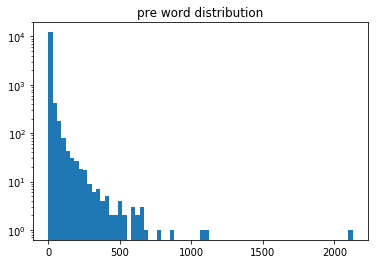

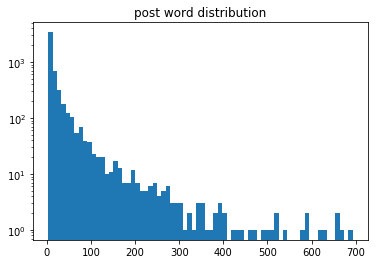

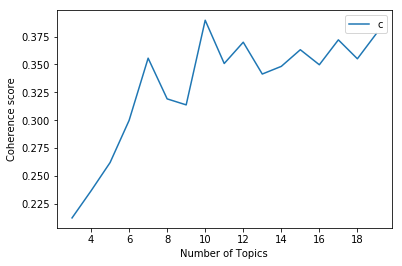

10
CPU times: user 3min 6s, sys: 8.03 s, total: 3min 14s
Wall time: 3min 10s


In [11]:
%%time
nTopicsPost, common_dictPost, corpusPost = processAndFindTopics(post)

10325 10325


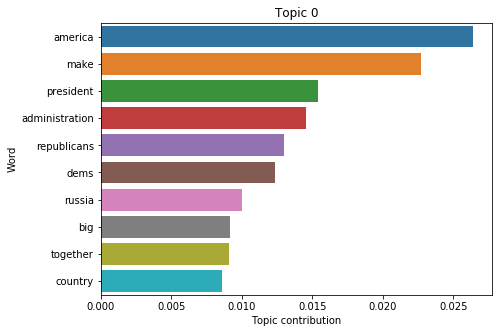

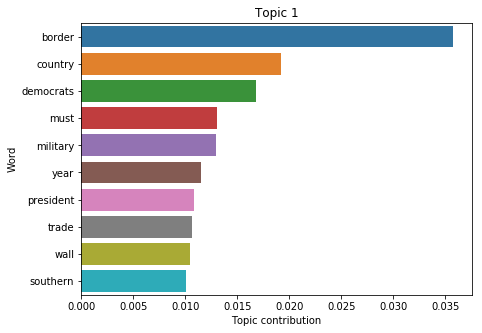

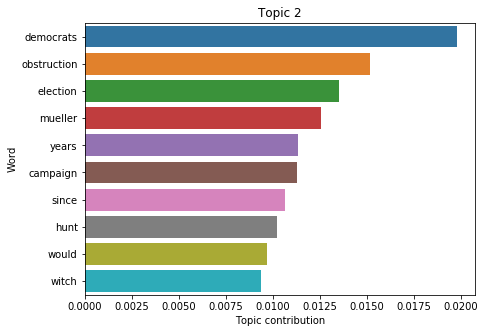

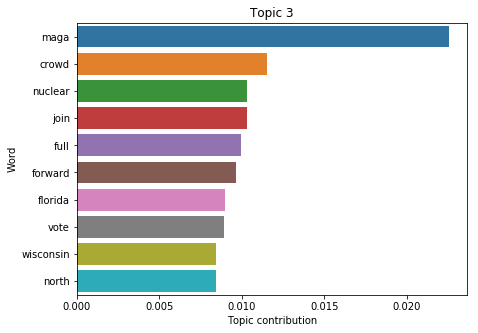

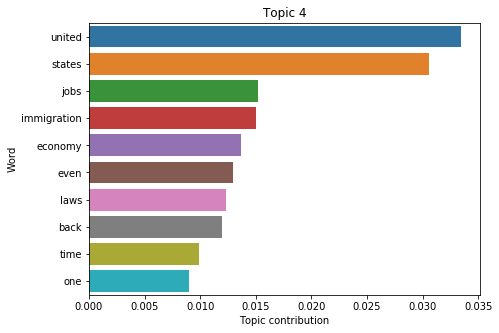

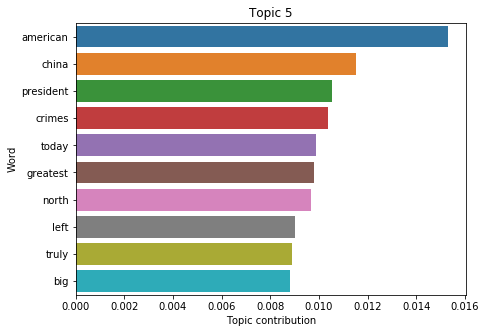

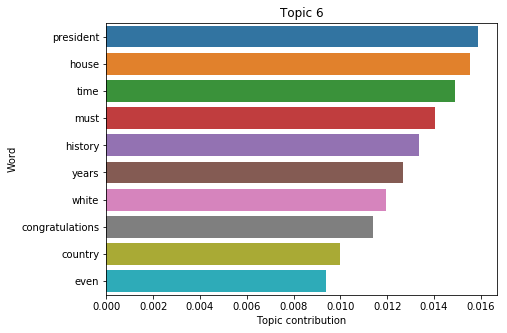

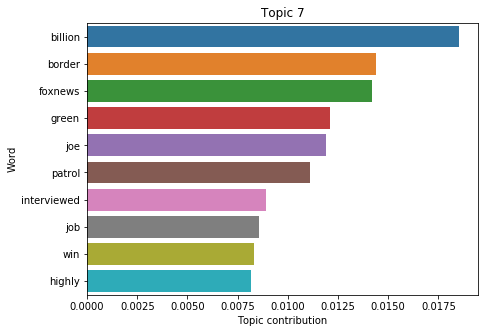

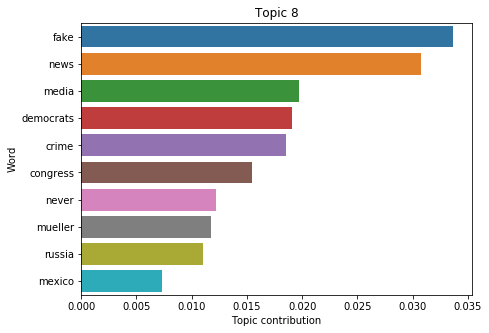

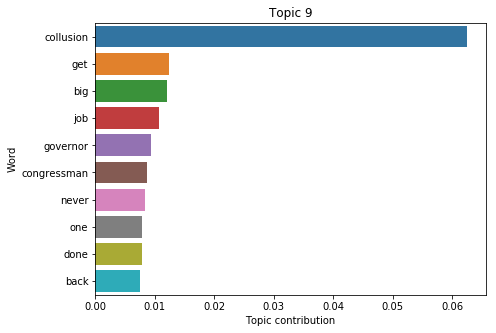

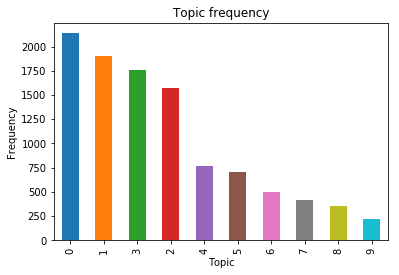

In [12]:
topicsPost = applyLda(post,nTopicsPost,corpusPost,common_dictPost)

0
NUMBER OF ELEMENTS FOR THIS TOPIC 2136
Corpus length in words: 28830


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


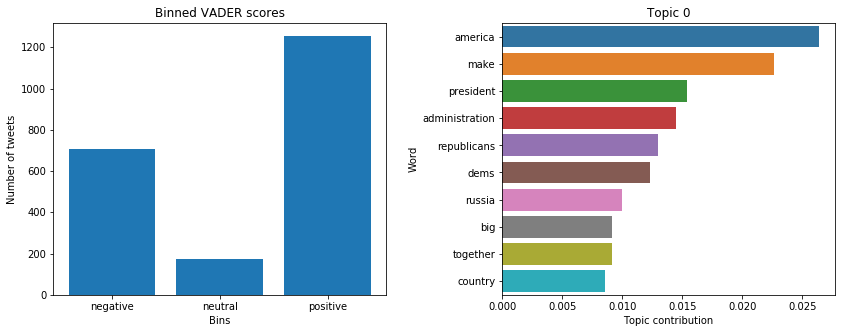

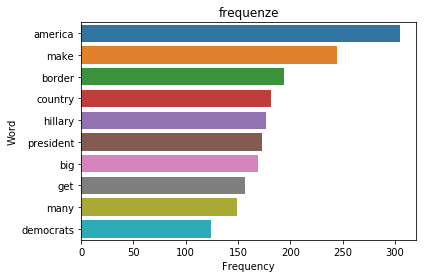

1
NUMBER OF ELEMENTS FOR THIS TOPIC 1905
Corpus length in words: 26706


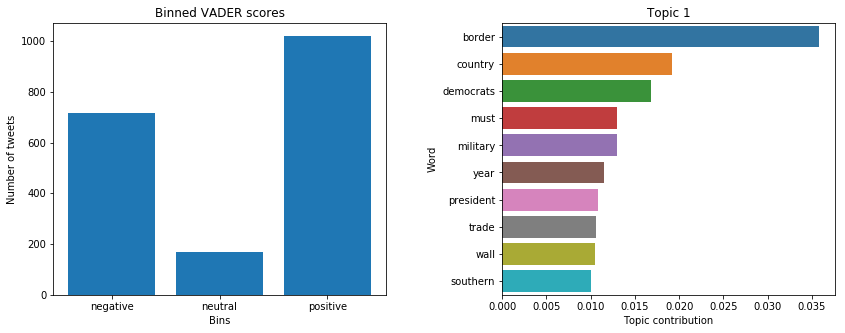

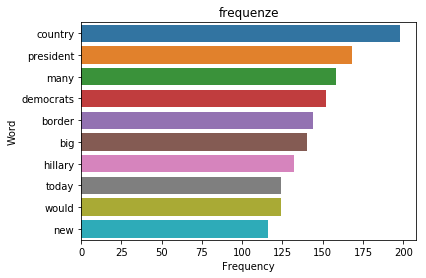

2
NUMBER OF ELEMENTS FOR THIS TOPIC 1569
Corpus length in words: 21820


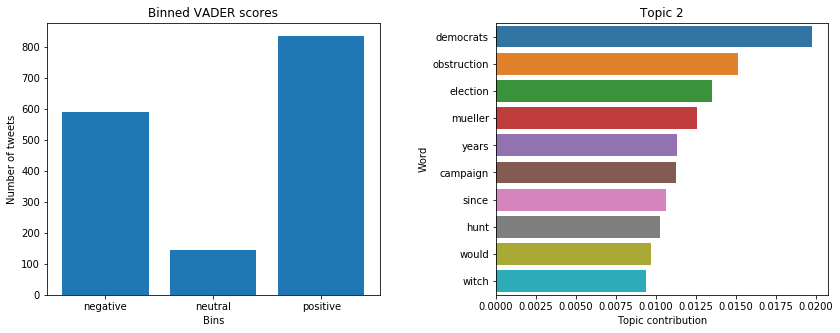

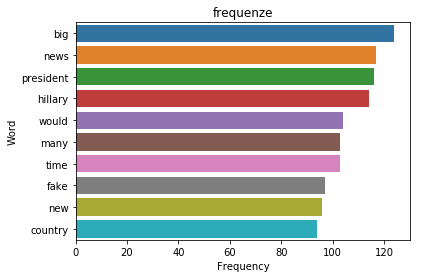

3
NUMBER OF ELEMENTS FOR THIS TOPIC 1758
Corpus length in words: 19840


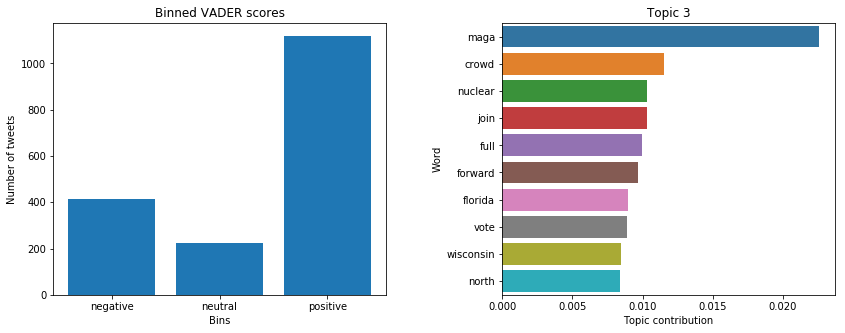

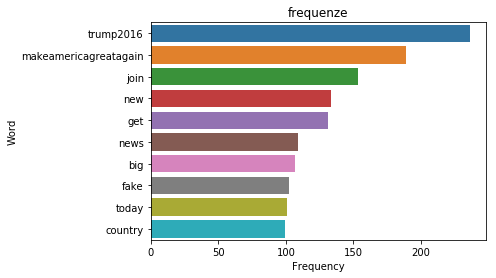

4
NUMBER OF ELEMENTS FOR THIS TOPIC 765
Corpus length in words: 10572


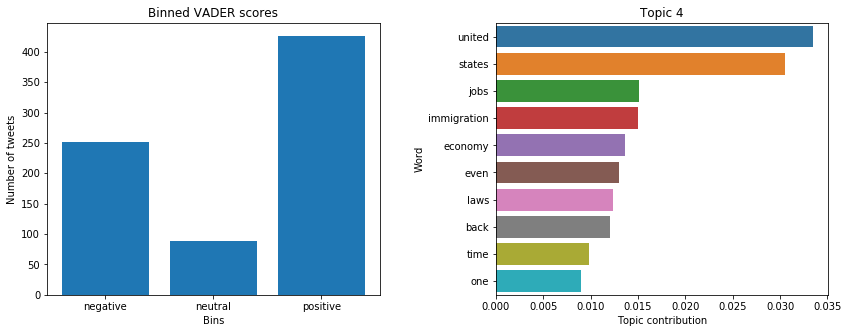

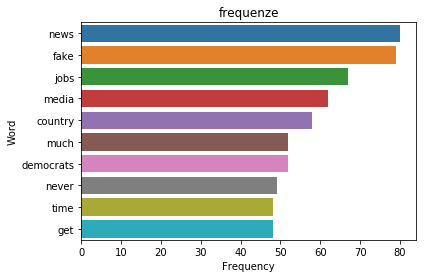

5
NUMBER OF ELEMENTS FOR THIS TOPIC 701
Corpus length in words: 6943


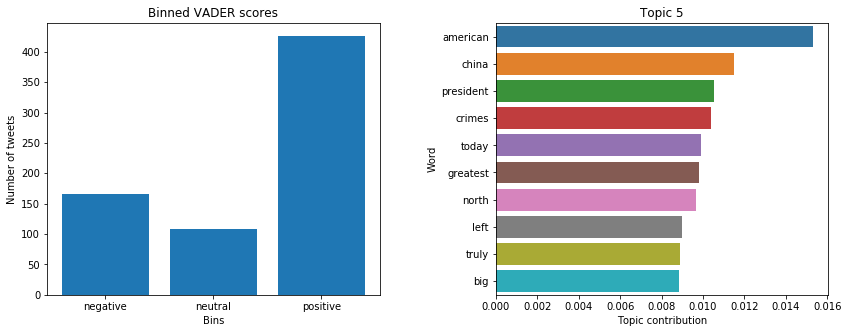

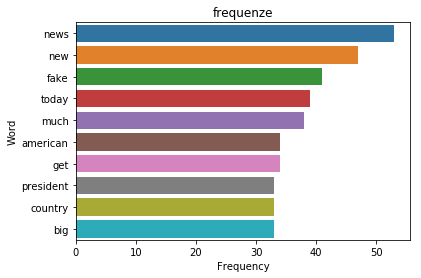

6
NUMBER OF ELEMENTS FOR THIS TOPIC 502
Corpus length in words: 4093


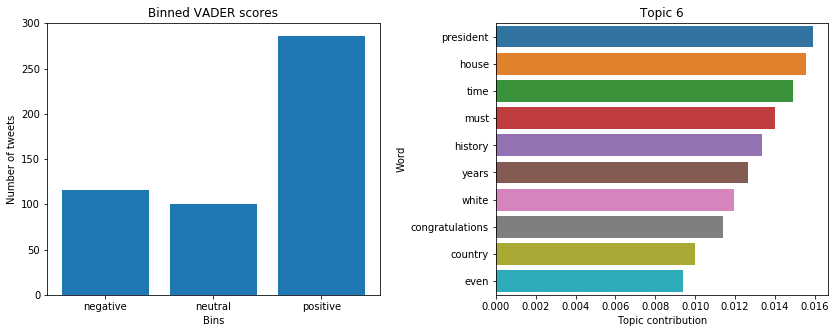

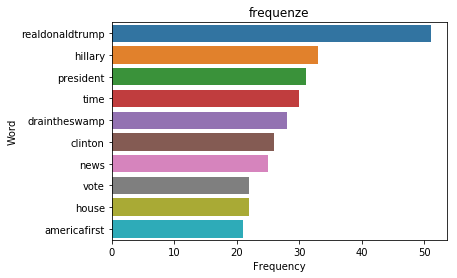

7
NUMBER OF ELEMENTS FOR THIS TOPIC 420
Corpus length in words: 2817


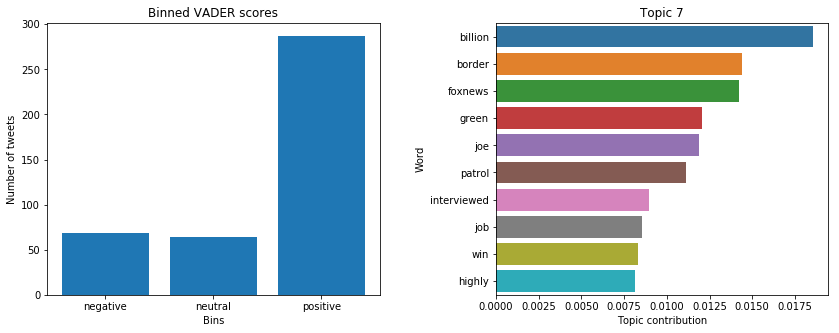

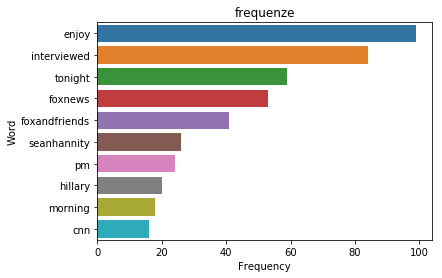

8
NUMBER OF ELEMENTS FOR THIS TOPIC 353
Corpus length in words: 1827


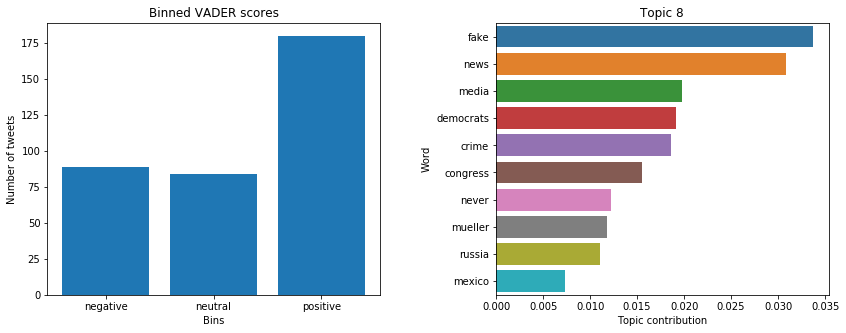

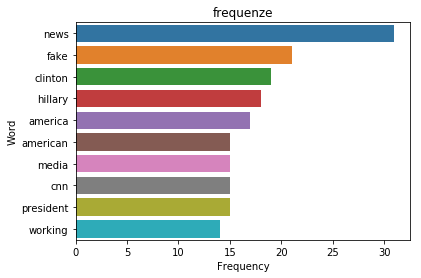

9
NUMBER OF ELEMENTS FOR THIS TOPIC 216
Corpus length in words: 1095


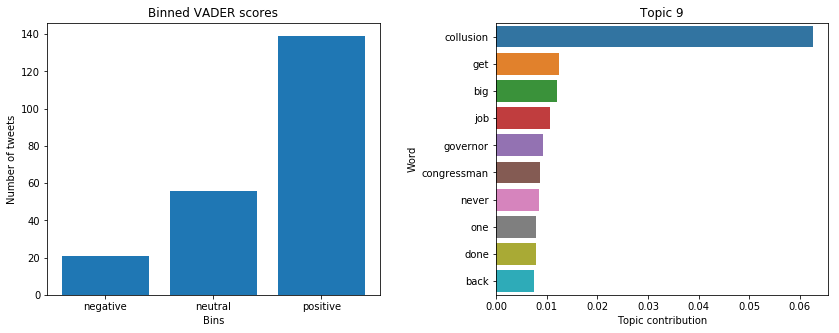

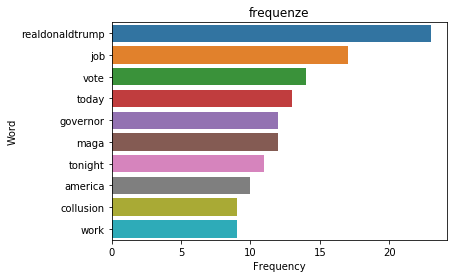

In [13]:
analyzeRes(post,topicsPost,0)

# pre election

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


34355


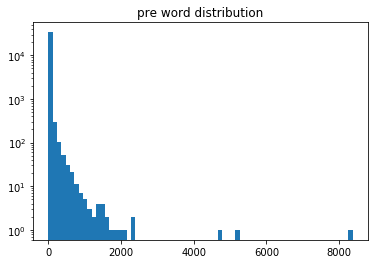

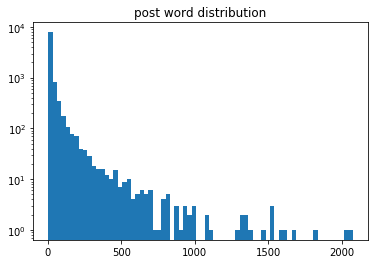

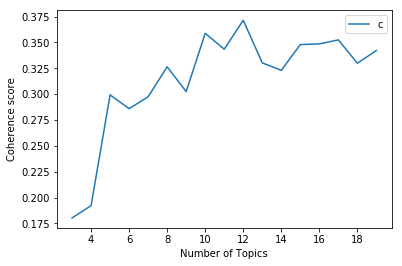

12


In [14]:
pre = data[data["year"] < 2016]
pre = data[data["year"] > 2009]
#così matcha dataset obama
pre=applyVader(pre)
nTopicsPre, common_dictPre, corpusPre = processAndFindTopics(pre)

36103 36103


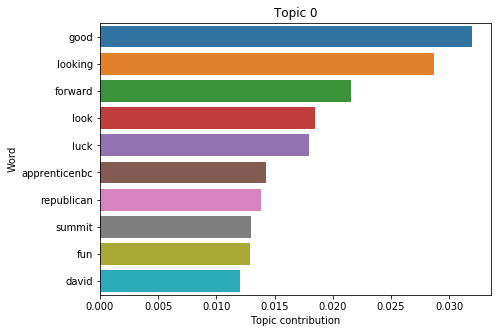

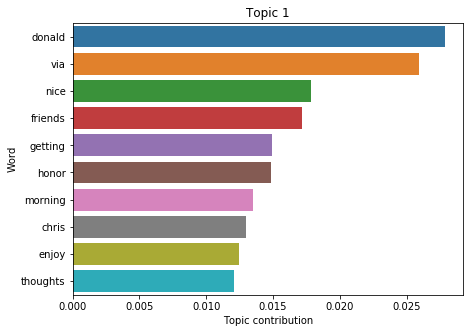

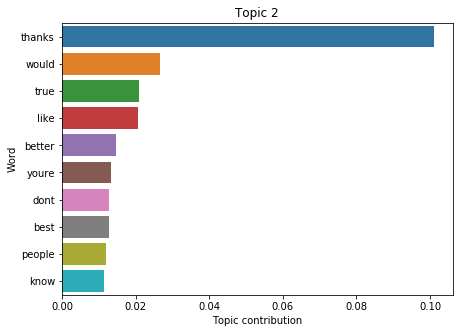

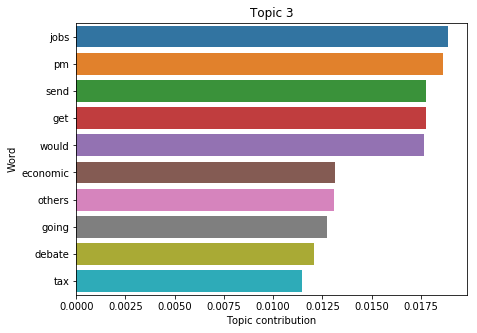

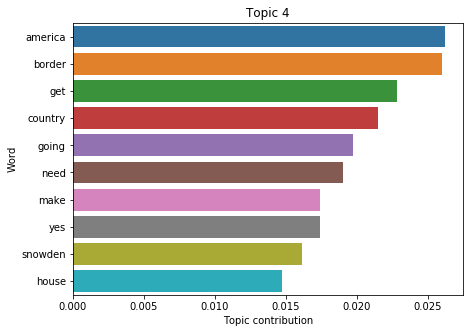

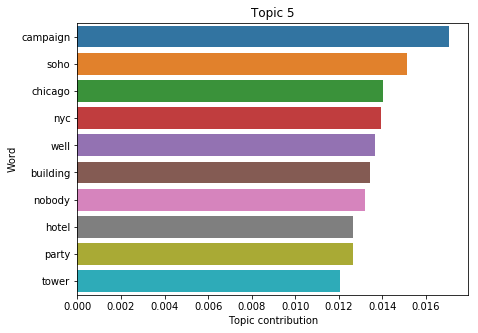

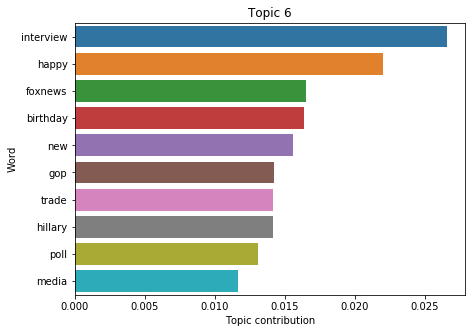

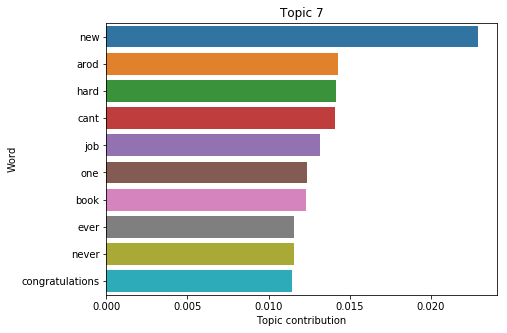

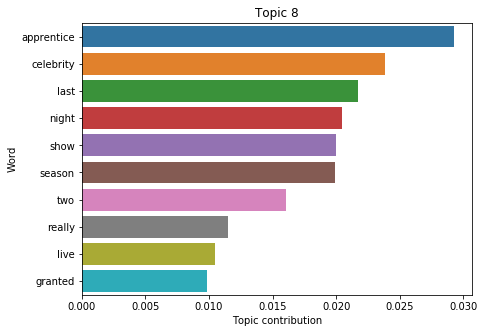

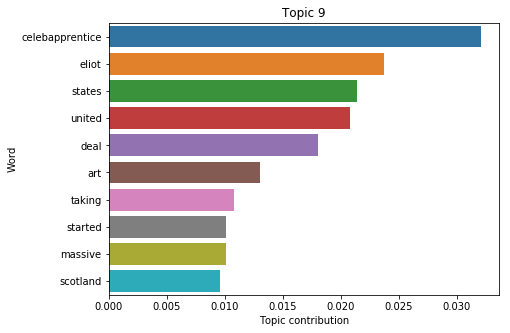

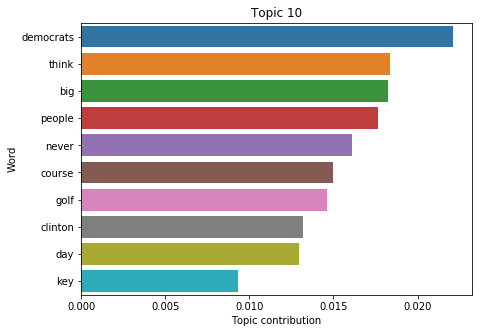

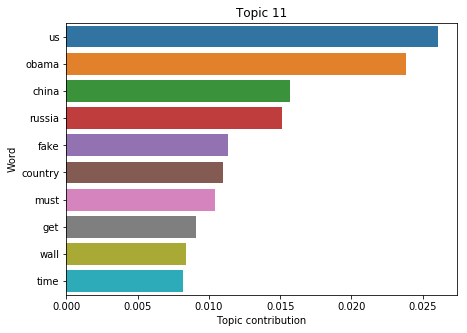

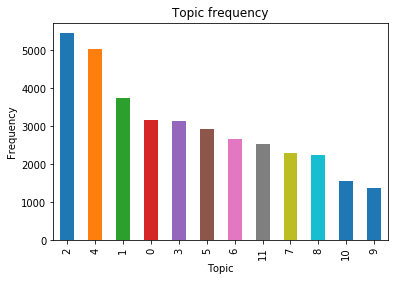

In [15]:
topics = applyLda(pre,nTopicsPre,corpusPre,common_dictPre)

0
NUMBER OF ELEMENTS FOR THIS TOPIC 3162
Corpus length in words: 31637


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


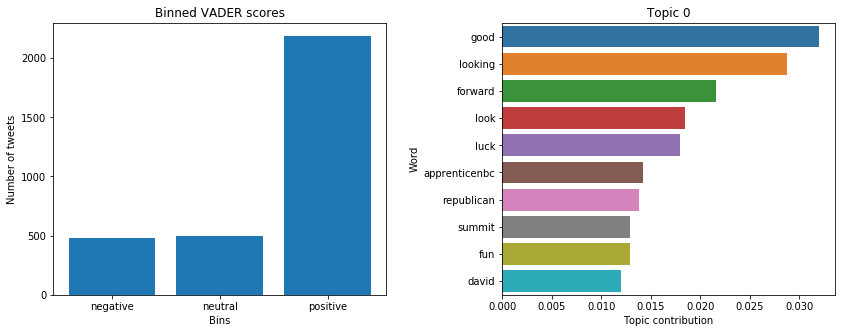

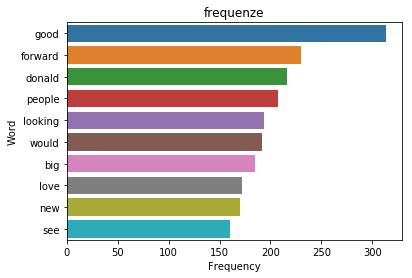

1
NUMBER OF ELEMENTS FOR THIS TOPIC 3735
Corpus length in words: 36245


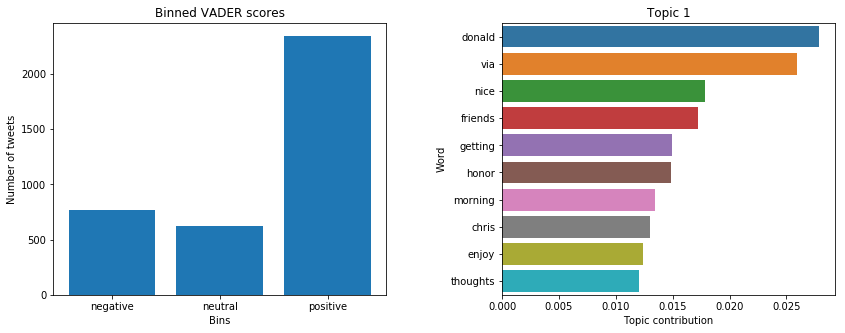

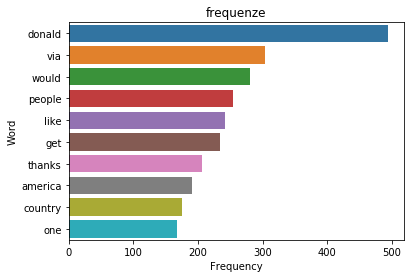

2
NUMBER OF ELEMENTS FOR THIS TOPIC 5455
Corpus length in words: 42620


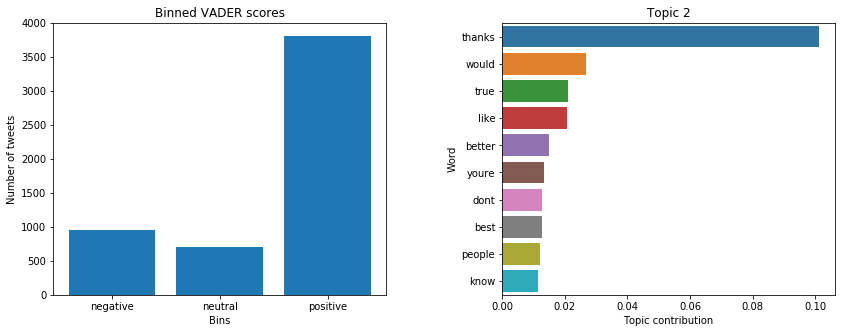

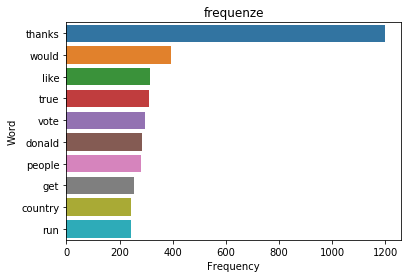

3
NUMBER OF ELEMENTS FOR THIS TOPIC 3139
Corpus length in words: 36718


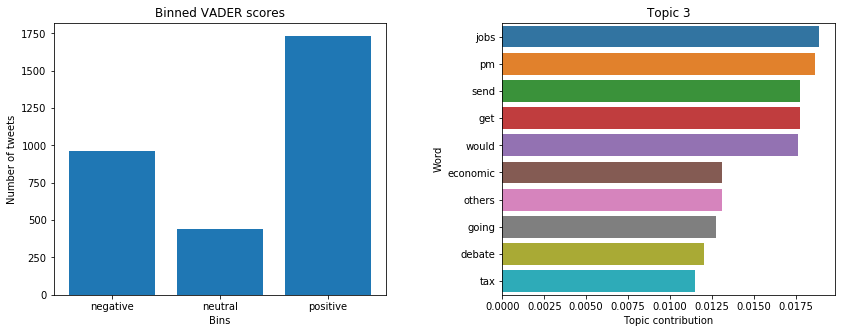

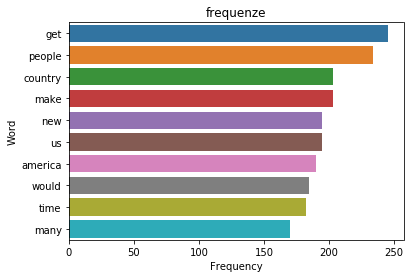

4
NUMBER OF ELEMENTS FOR THIS TOPIC 5020
Corpus length in words: 47568


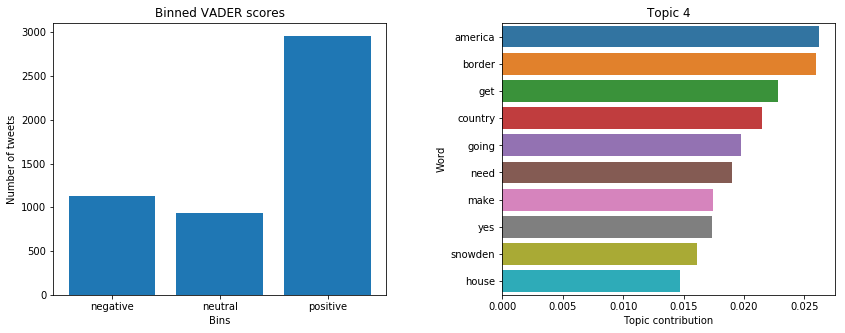

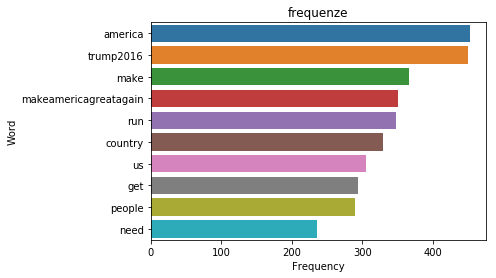

5
NUMBER OF ELEMENTS FOR THIS TOPIC 2936
Corpus length in words: 35460


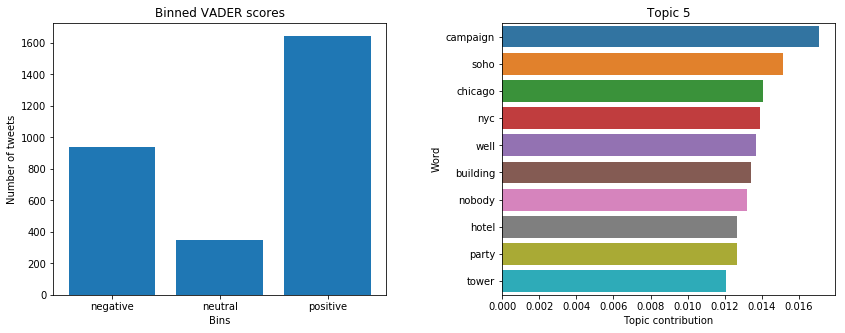

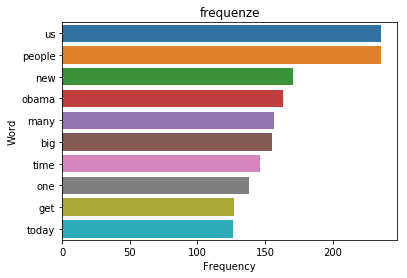

6
NUMBER OF ELEMENTS FOR THIS TOPIC 2653
Corpus length in words: 27884


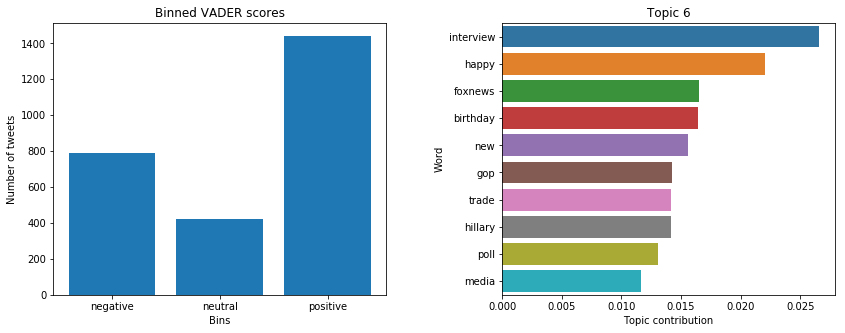

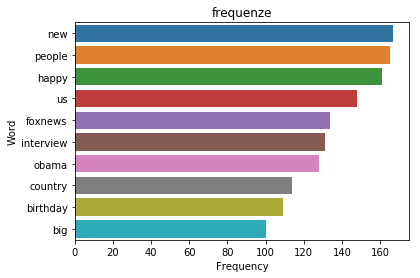

7
NUMBER OF ELEMENTS FOR THIS TOPIC 2296
Corpus length in words: 20831


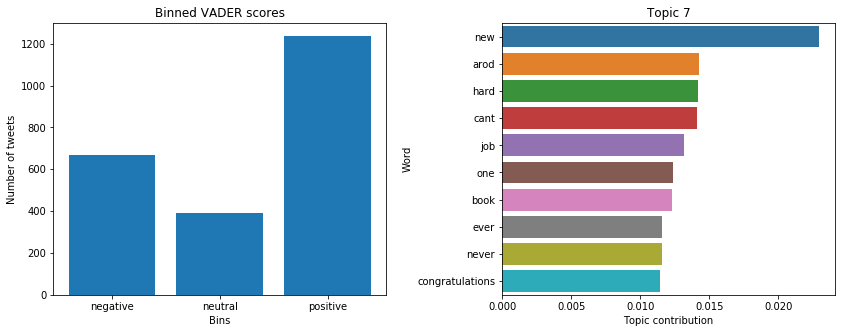

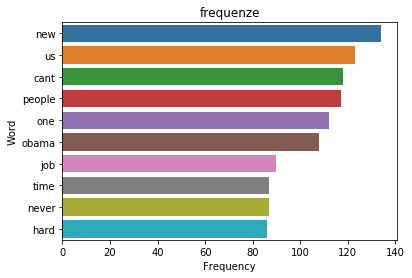

8
NUMBER OF ELEMENTS FOR THIS TOPIC 2240
Corpus length in words: 17206


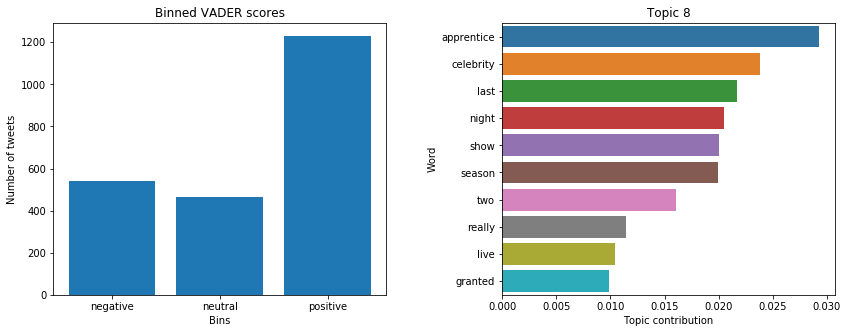

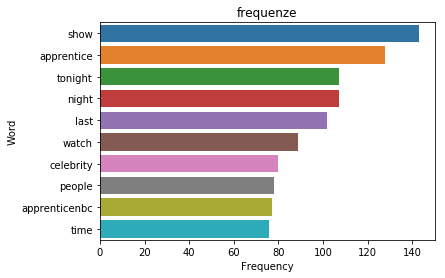

9
NUMBER OF ELEMENTS FOR THIS TOPIC 1370
Corpus length in words: 10013


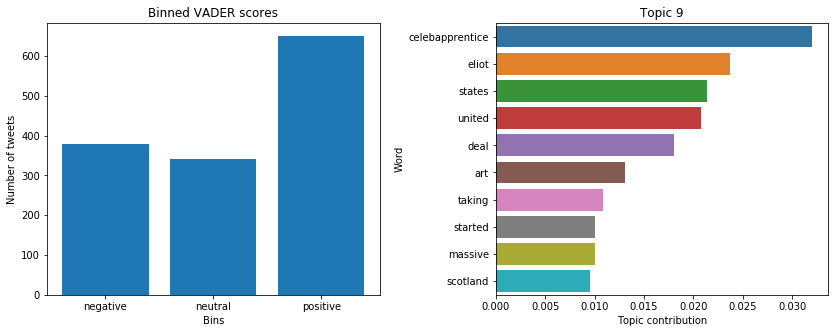

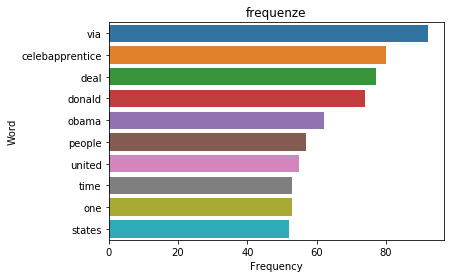

10
NUMBER OF ELEMENTS FOR THIS TOPIC 1557
Corpus length in words: 11627


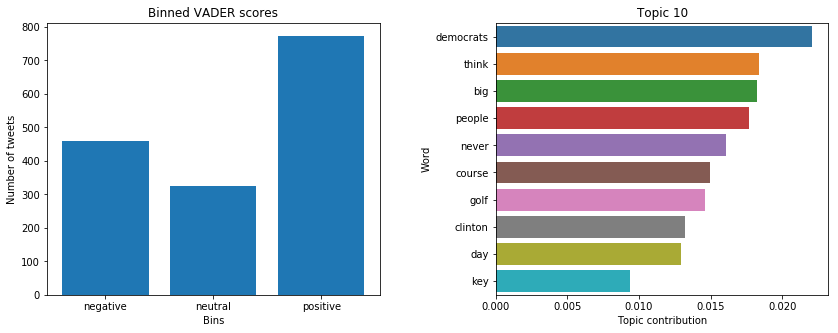

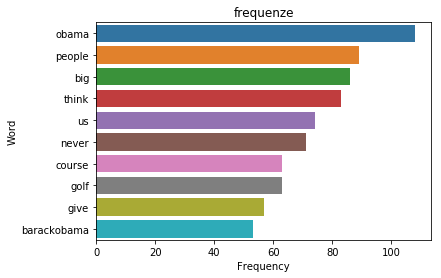

11
NUMBER OF ELEMENTS FOR THIS TOPIC 2540
Corpus length in words: 13832


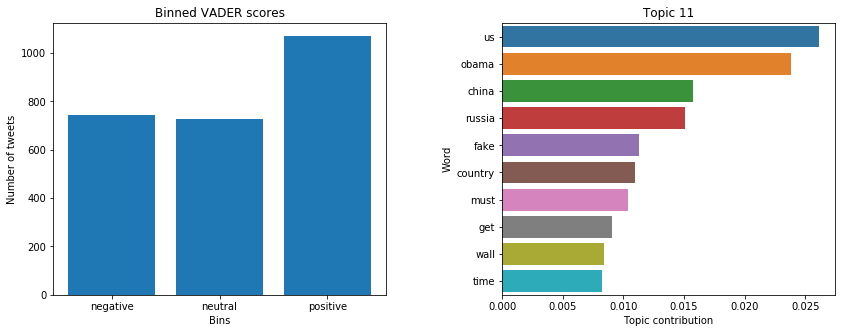

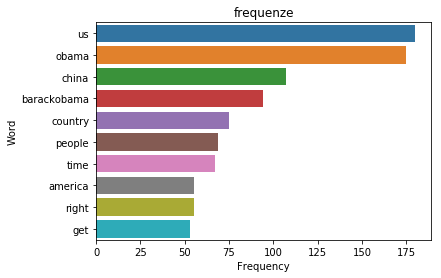

In [16]:
analyzeRes(pre,topics,0)

# Obama

14706


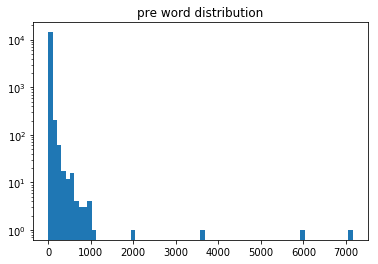

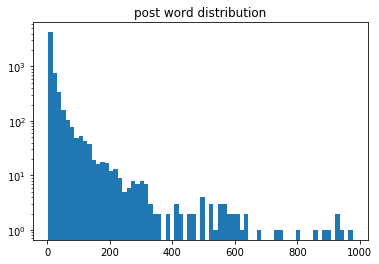

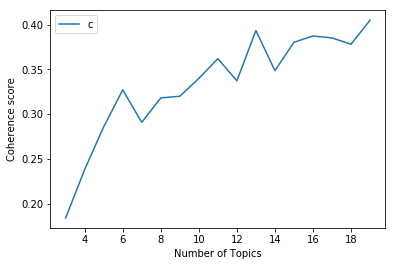

19


In [17]:
obama = pd.read_csv("obamaprocessed.csv")
obama = applyVader1(obama)
nTopicsOba, common_dictOba, corpusOba = processAndFindTopics(obama)

18469 18469


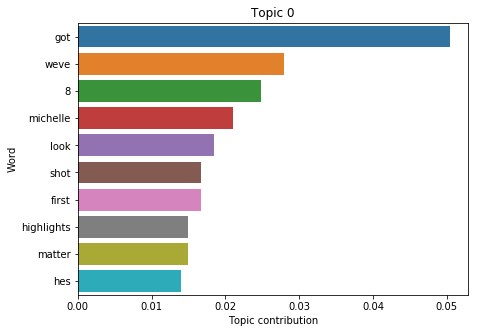

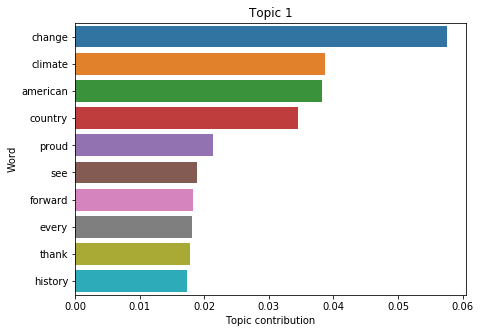

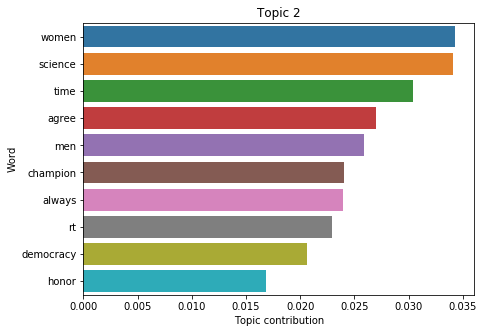

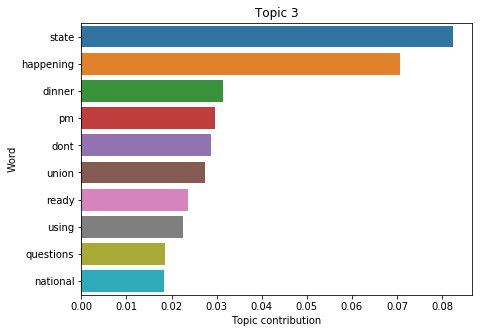

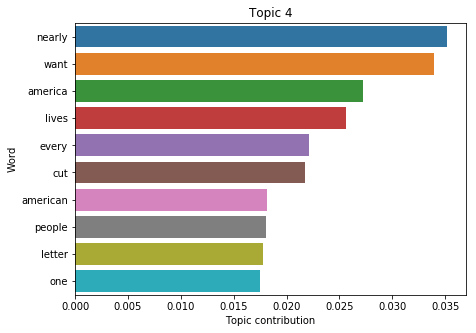

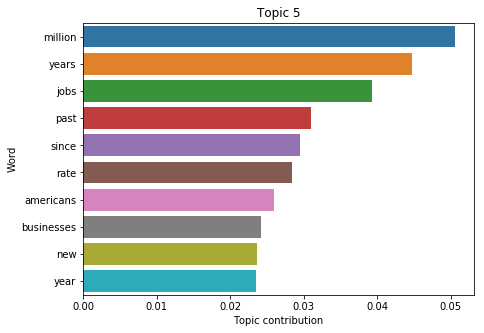

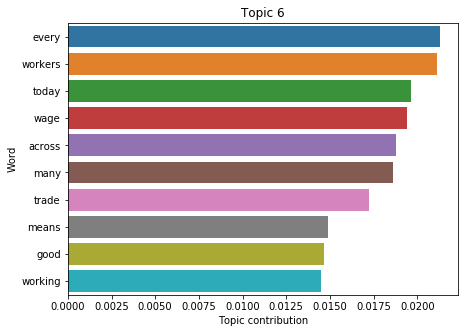

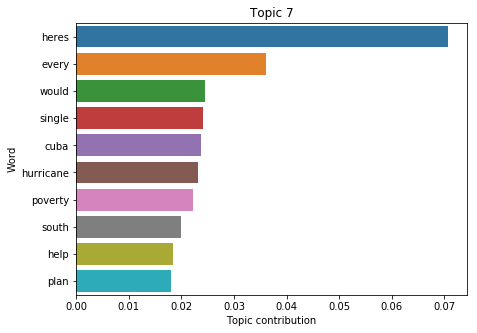

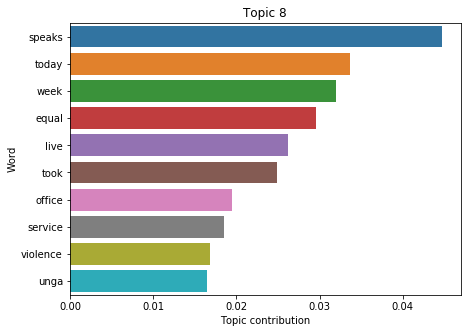

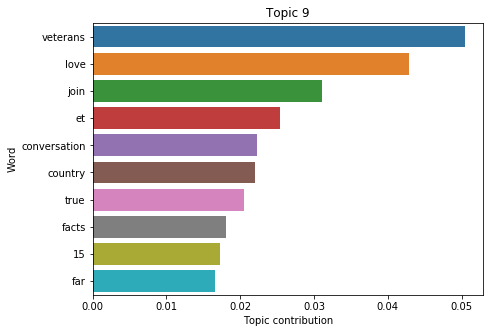

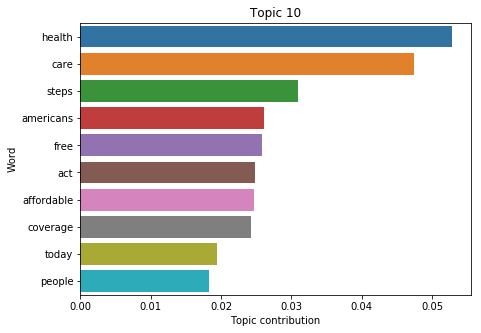

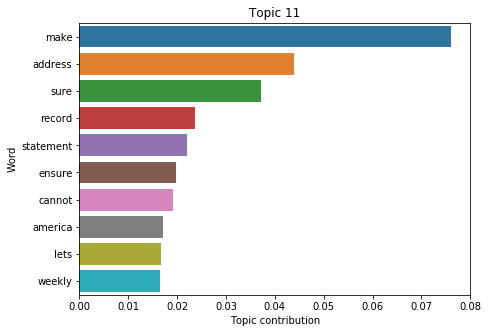

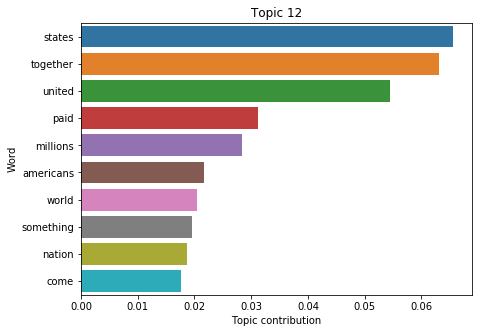

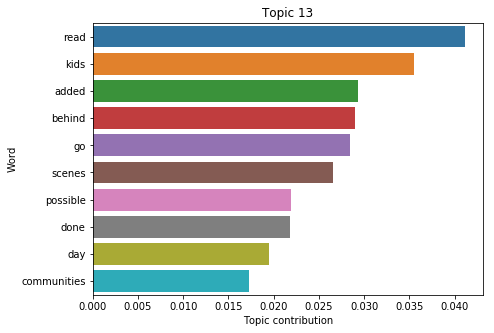

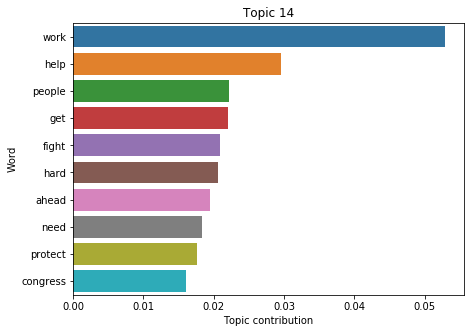

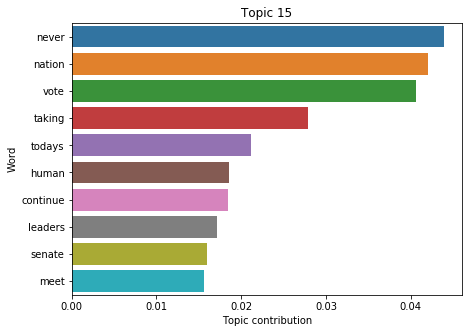

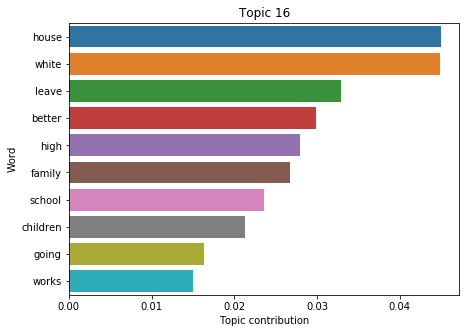

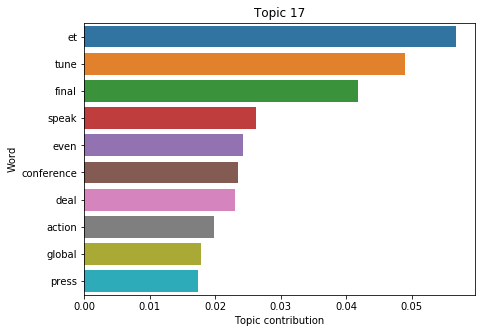

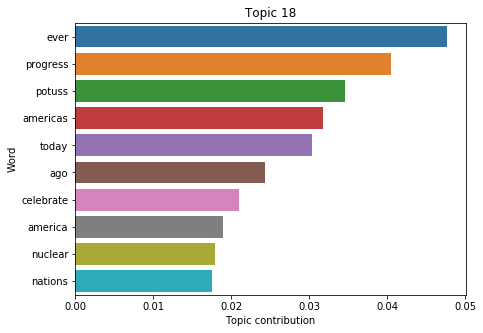

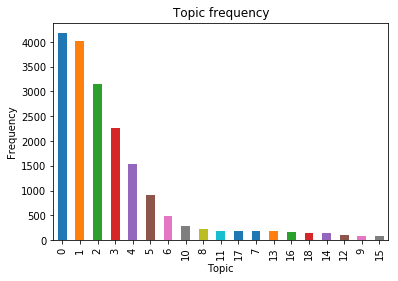

In [18]:
topics = applyLda(obama,nTopicsOba,corpusOba,common_dictOba)

0
NUMBER OF ELEMENTS FOR THIS TOPIC 4182
Corpus length in words: 38730


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


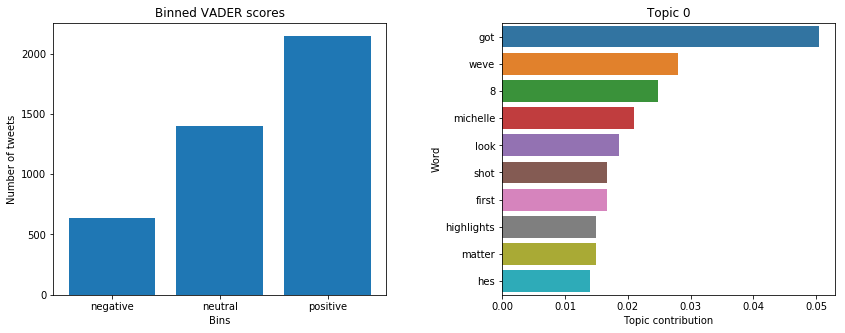

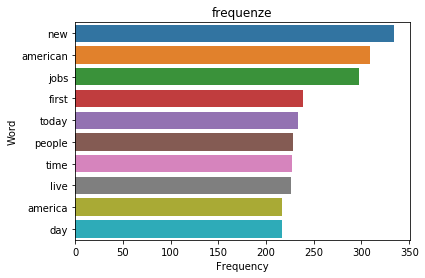

1
NUMBER OF ELEMENTS FOR THIS TOPIC 4018
Corpus length in words: 36992


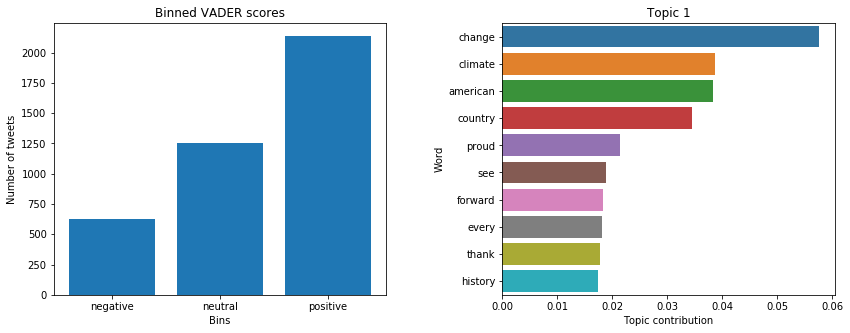

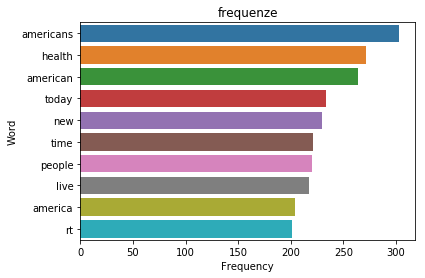

2
NUMBER OF ELEMENTS FOR THIS TOPIC 3147
Corpus length in words: 29119


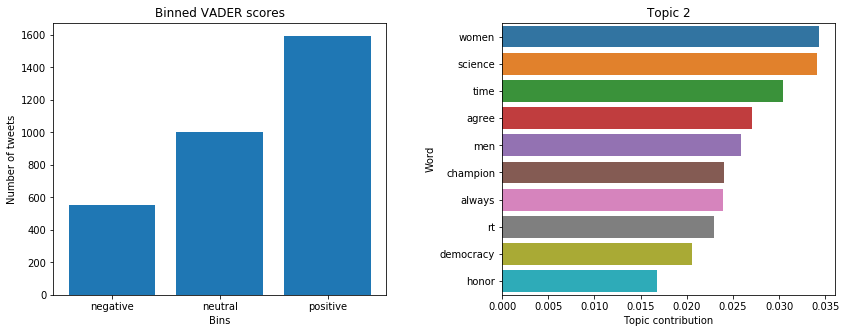

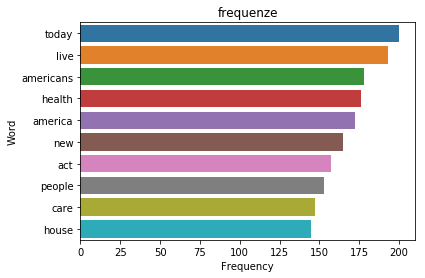

3
NUMBER OF ELEMENTS FOR THIS TOPIC 2256
Corpus length in words: 20608


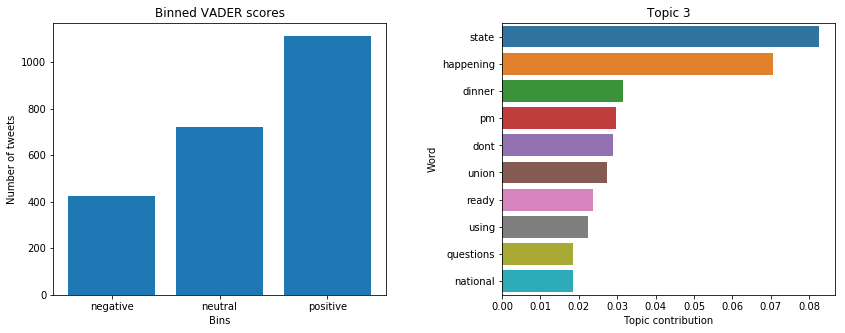

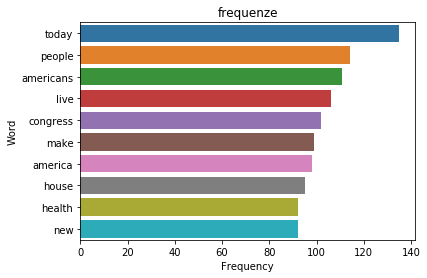

4
NUMBER OF ELEMENTS FOR THIS TOPIC 1541
Corpus length in words: 13173


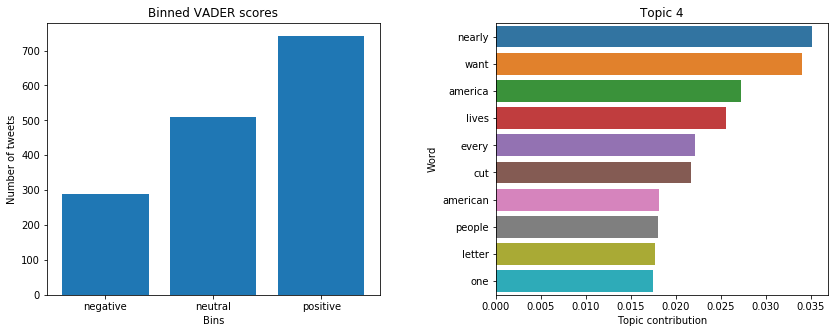

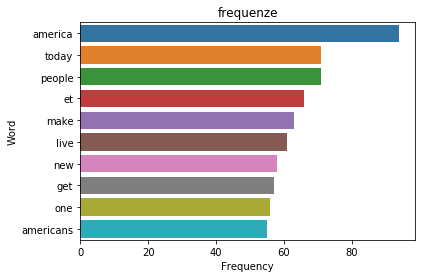

5
NUMBER OF ELEMENTS FOR THIS TOPIC 909
Corpus length in words: 7117


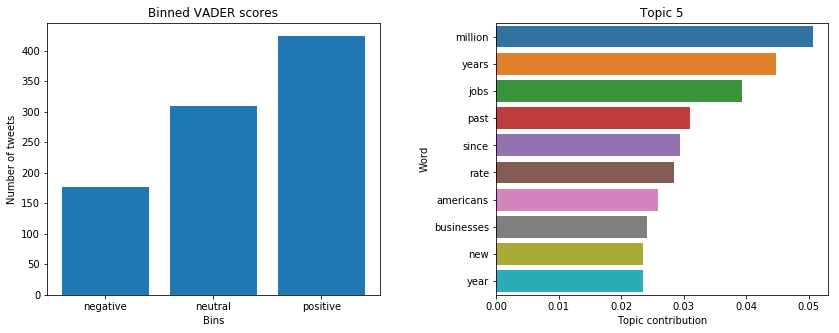

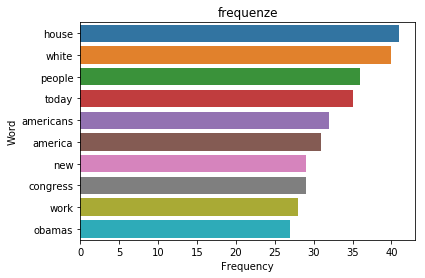

6
NUMBER OF ELEMENTS FOR THIS TOPIC 485
Corpus length in words: 3420


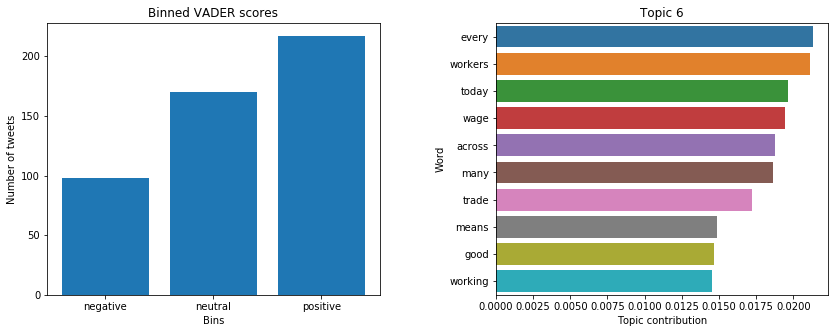

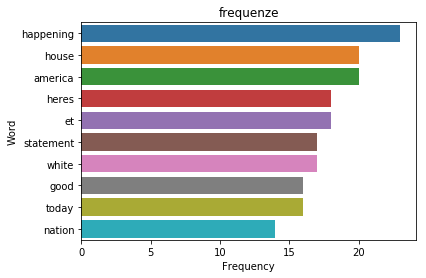

7
NUMBER OF ELEMENTS FOR THIS TOPIC 174
Corpus length in words: 1063


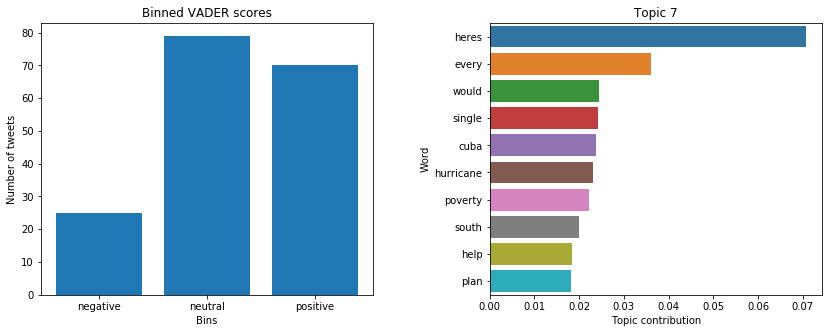

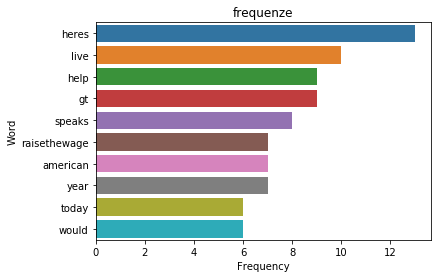

8
NUMBER OF ELEMENTS FOR THIS TOPIC 219
Corpus length in words: 1020


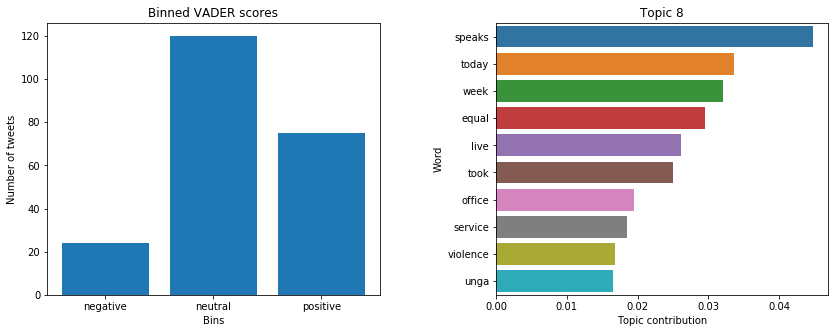

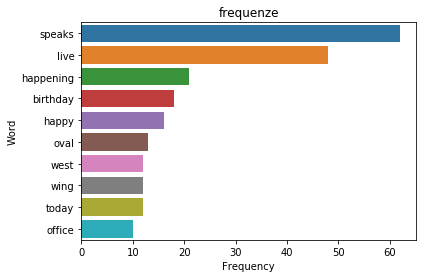

9
NUMBER OF ELEMENTS FOR THIS TOPIC 90
Corpus length in words: 417


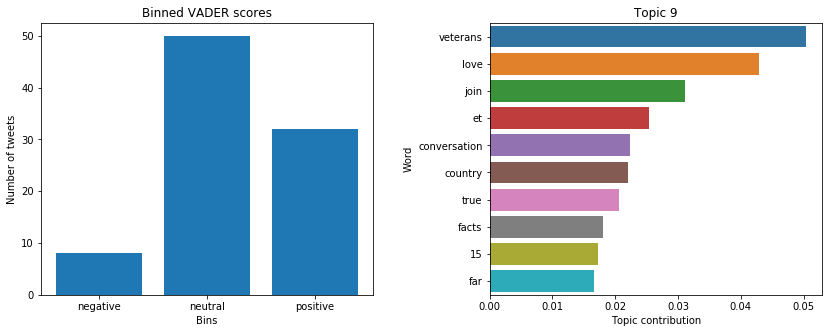

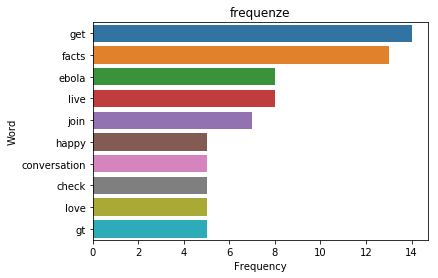

10
NUMBER OF ELEMENTS FOR THIS TOPIC 285
Corpus length in words: 1384


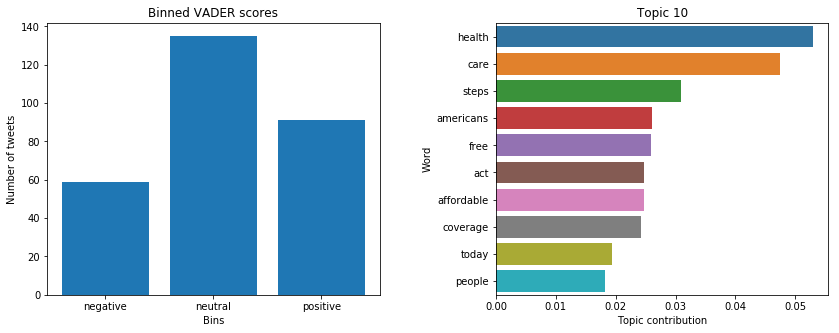

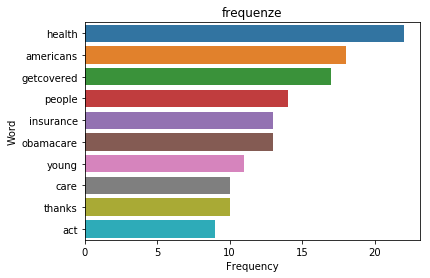

11
NUMBER OF ELEMENTS FOR THIS TOPIC 184
Corpus length in words: 922


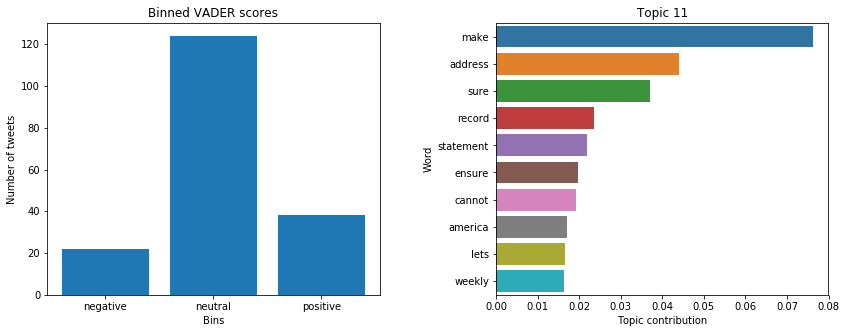

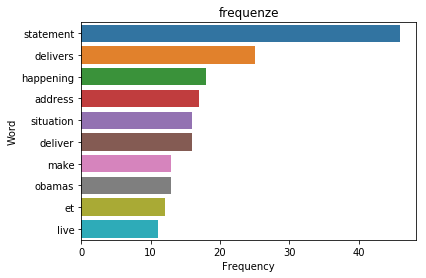

12
NUMBER OF ELEMENTS FOR THIS TOPIC 96
Corpus length in words: 487


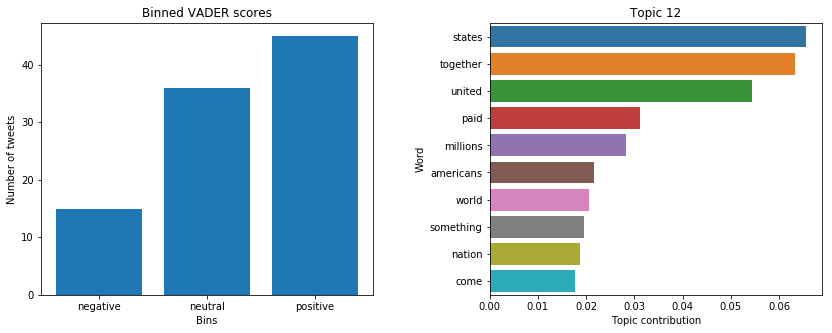

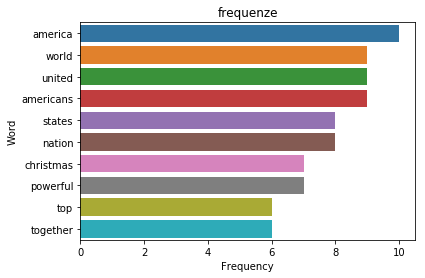

13
NUMBER OF ELEMENTS FOR THIS TOPIC 173
Corpus length in words: 820


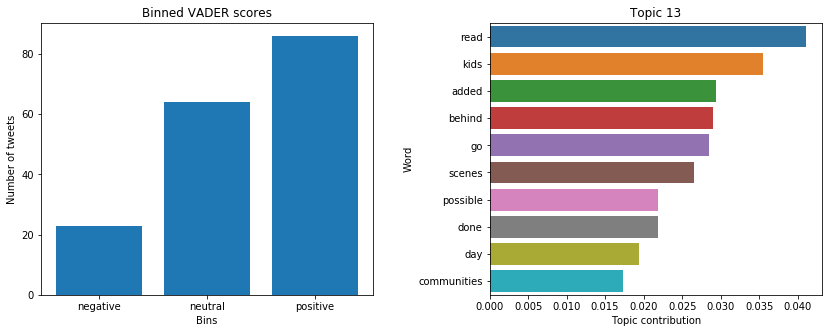

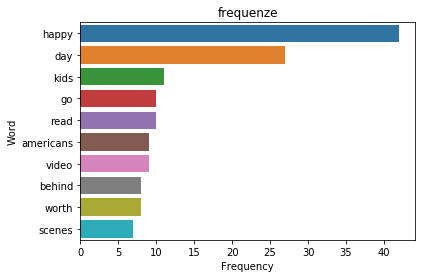

14
NUMBER OF ELEMENTS FOR THIS TOPIC 137
Corpus length in words: 803


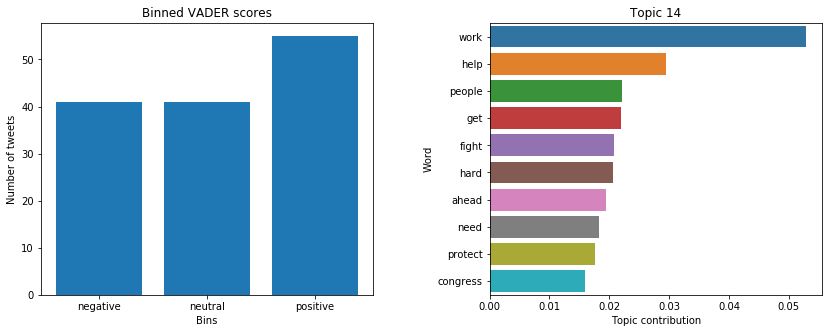

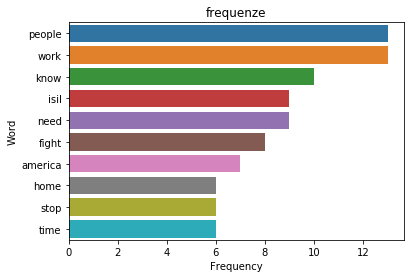

15
NUMBER OF ELEMENTS FOR THIS TOPIC 84
Corpus length in words: 438


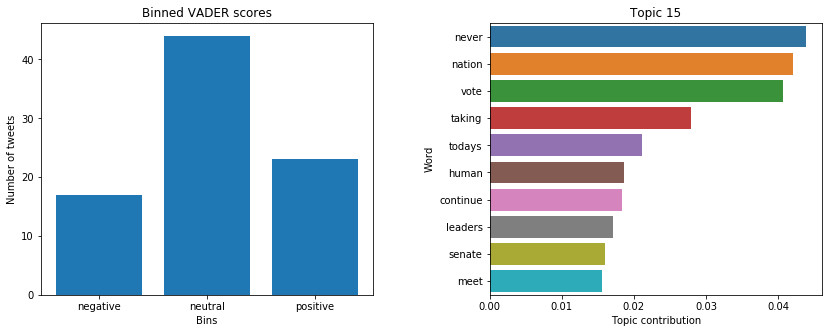

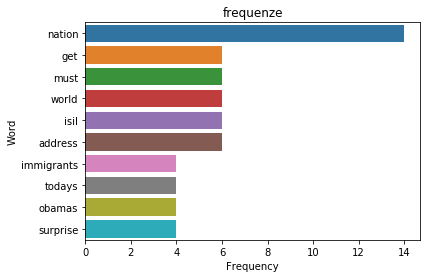

16
NUMBER OF ELEMENTS FOR THIS TOPIC 160
Corpus length in words: 770


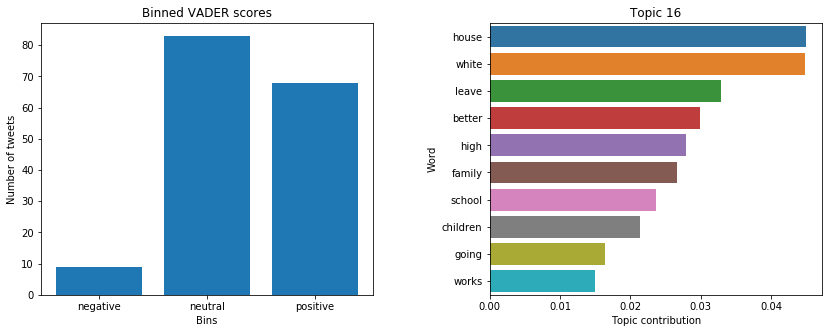

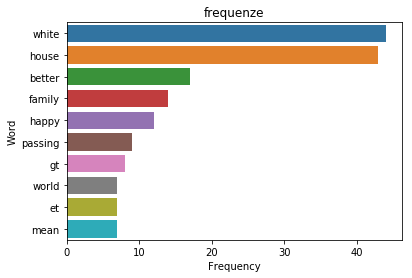

17
NUMBER OF ELEMENTS FOR THIS TOPIC 183
Corpus length in words: 1014


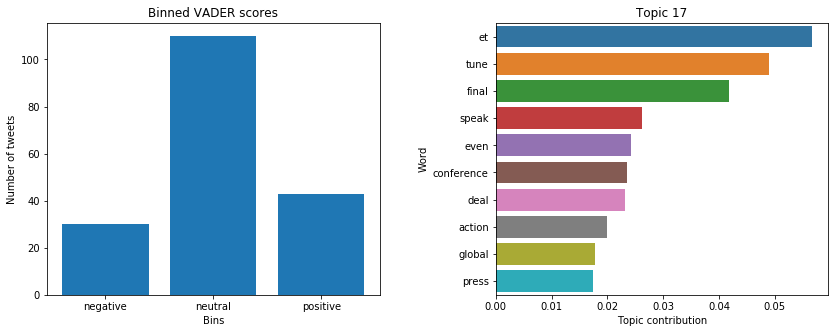

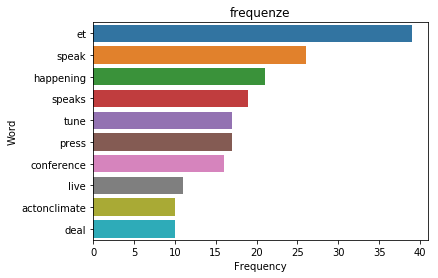

18
NUMBER OF ELEMENTS FOR THIS TOPIC 146
Corpus length in words: 783


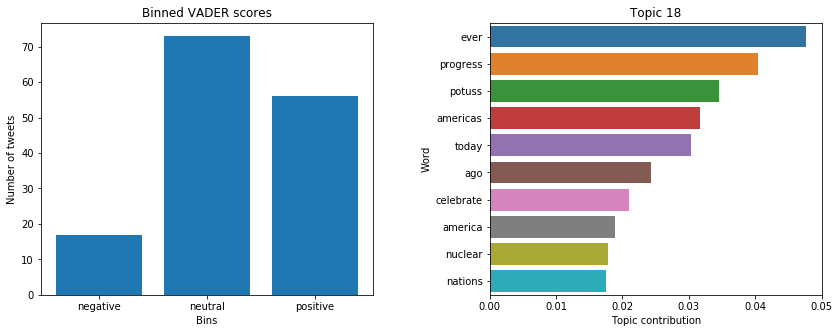

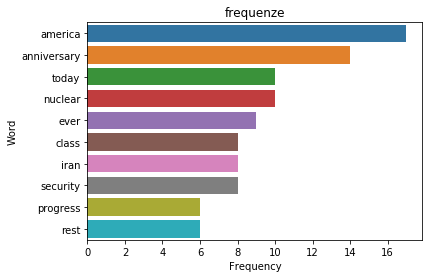

In [19]:
analyzeRes(obama,topics,0)

# PROVA A SUDDIVIDERE DATASET IN SENTIMENT NEGATIVO/NEUTRO/POSITIVO E APPLICA LDA PER VEDERE DI CHE PARLA

In [49]:
pre = data[data["year"] < 2016]
pre = data[data["year"] > 2009]
#così matcha dataset obama
pre=applyVader(pre)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


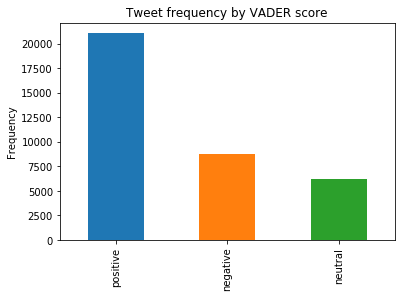

In [50]:
plt.title("Tweet frequency by VADER score")
plt.ylabel("Frequency")
pre["vaderScoreBinned"].value_counts().plot(kind="bar")

In [51]:
pre = pre[pre["vaderScoreBinned"] == "negative"]
print(len(pre))

8802


14525


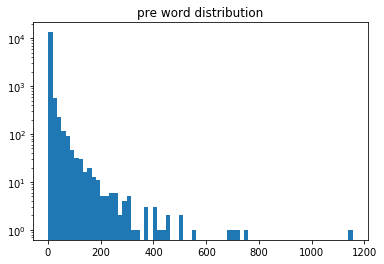

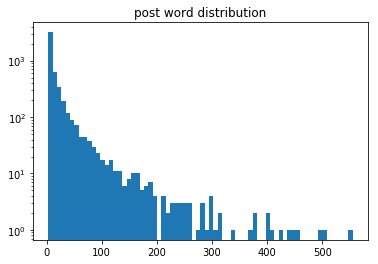

KeyboardInterrupt: 

In [52]:
ntop, common_dict, corpus = procAndTopicsTagged(pre)

In [ ]:
topics = applyLda(pre,ntop,corpus,common_dict)

In [ ]:
analyzeRes(pre,topics,1)

# POST 

In [40]:
post = data[data["year"] >= 2016]
post = applyVader(post)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


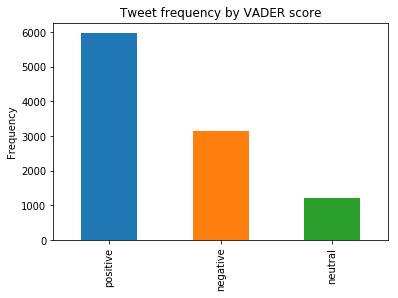

In [44]:
plt.title("Tweet frequency by VADER score")
plt.ylabel("Frequency")
post["vaderScoreBinned"].value_counts().plot(kind="bar")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


5973
9553


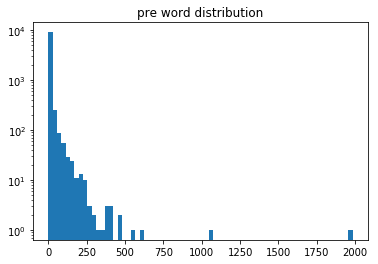

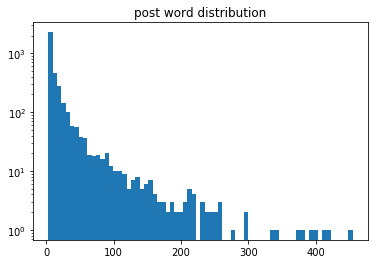

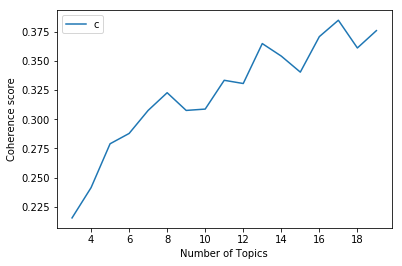

17


In [34]:
post = post[post["vaderScoreBinned"] == "positive"]
print(len(post))
postTop, common_dictPost, corpusPost = procAndTopicsTagged(post)

5973 5973


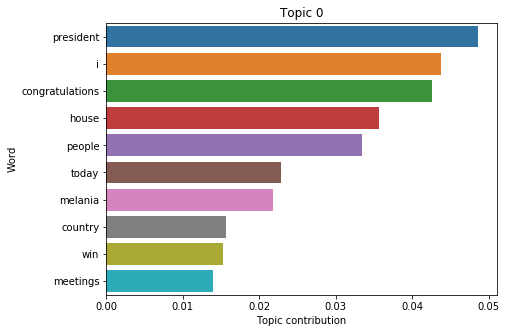

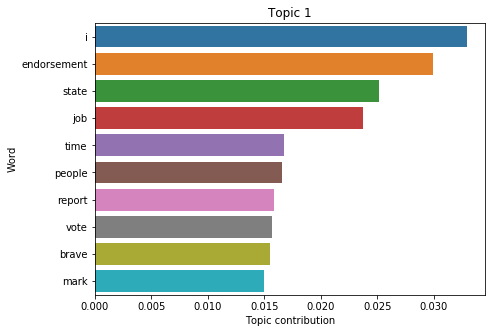

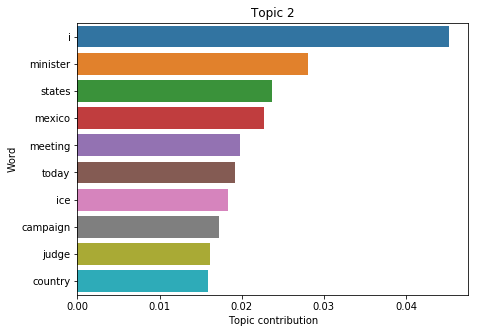

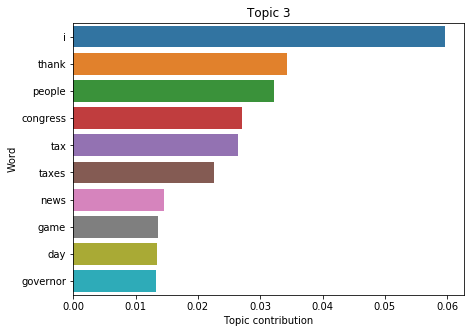

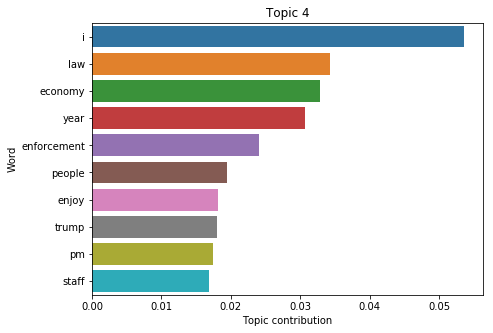

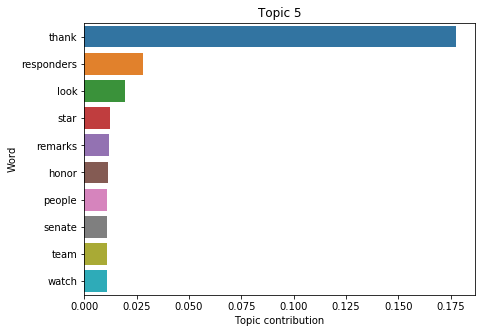

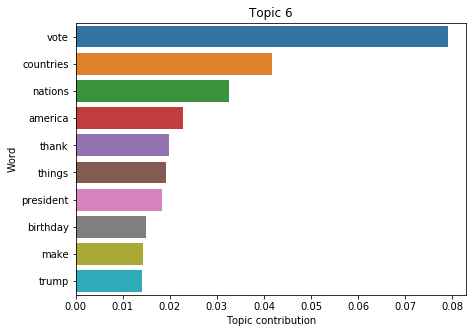

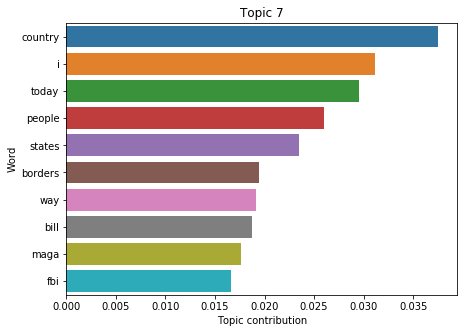

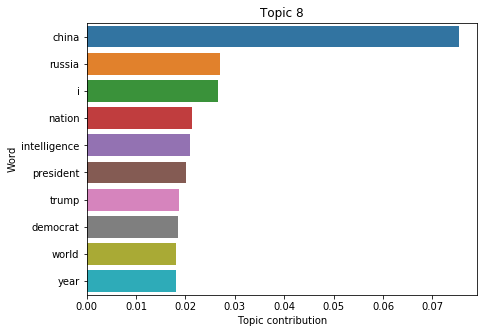

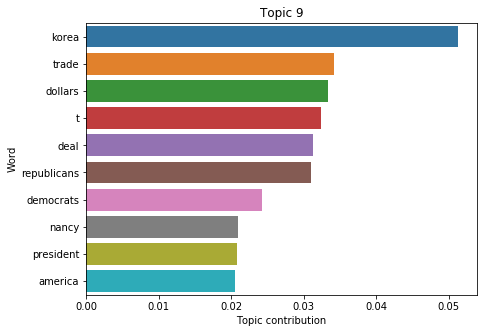

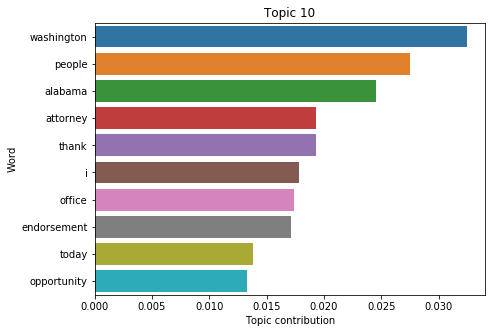

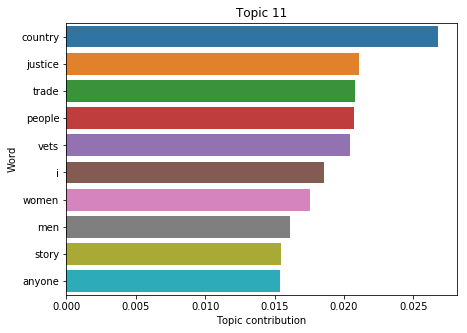

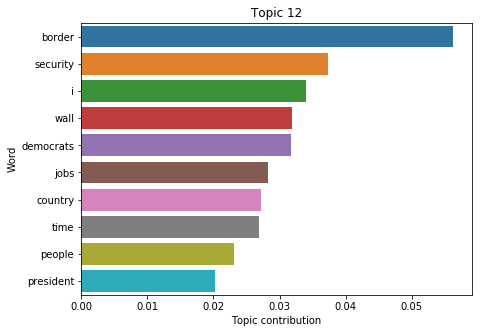

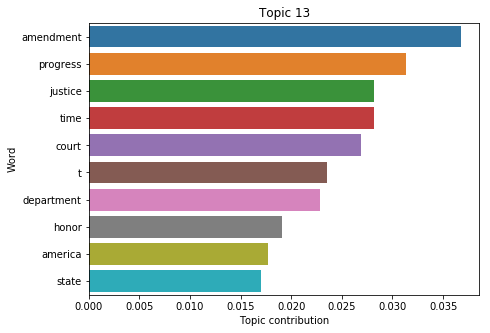

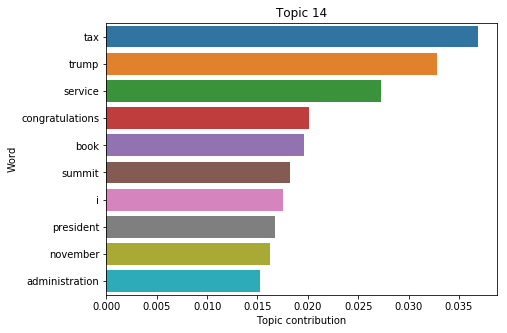

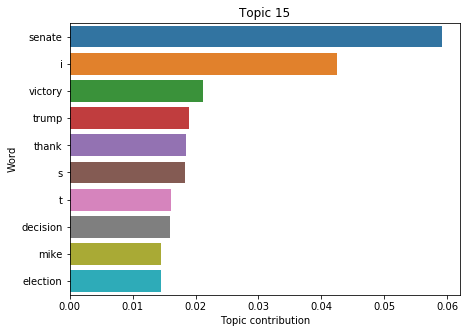

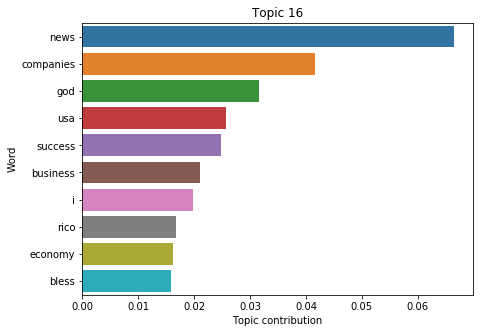

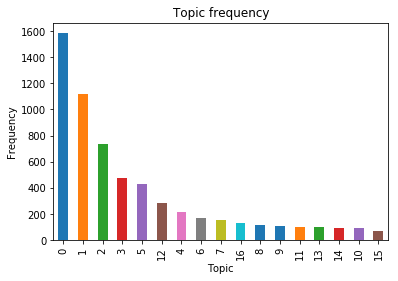

In [35]:
topicsPost = applyLda(post,postTop,corpusPost,common_dictPost)

0
NUMBER OF ELEMENTS FOR THIS TOPIC 1586
Corpus length in words: 20300


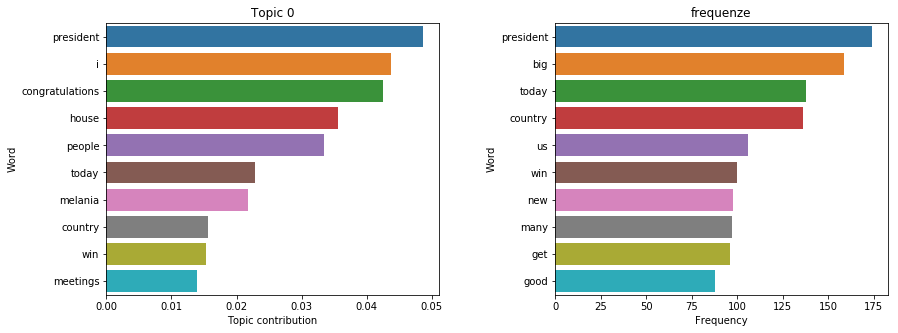

1
NUMBER OF ELEMENTS FOR THIS TOPIC 1122
Corpus length in words: 15764


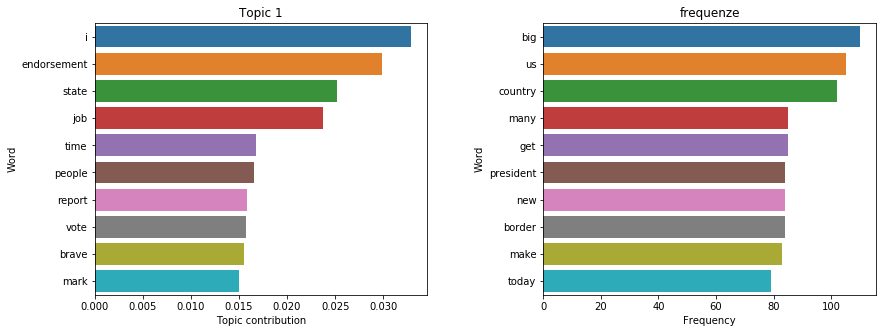

2
NUMBER OF ELEMENTS FOR THIS TOPIC 737
Corpus length in words: 10824


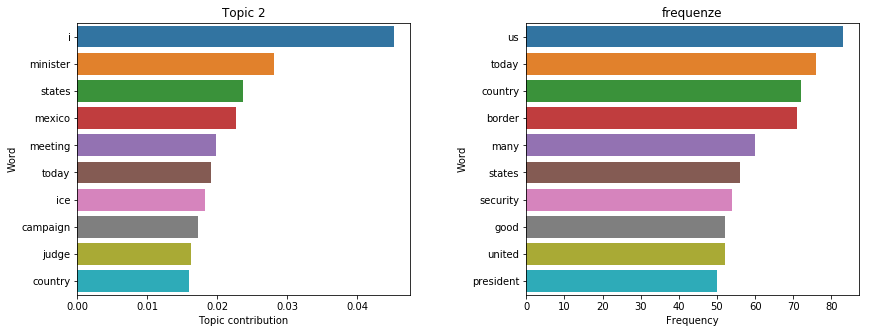

3
NUMBER OF ELEMENTS FOR THIS TOPIC 473
Corpus length in words: 5819


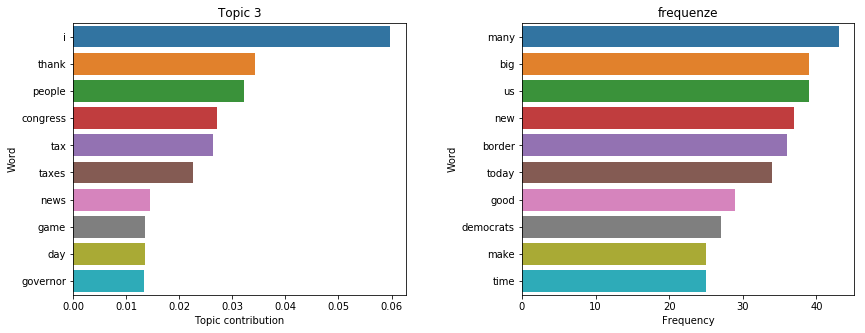

4
NUMBER OF ELEMENTS FOR THIS TOPIC 211
Corpus length in words: 2208


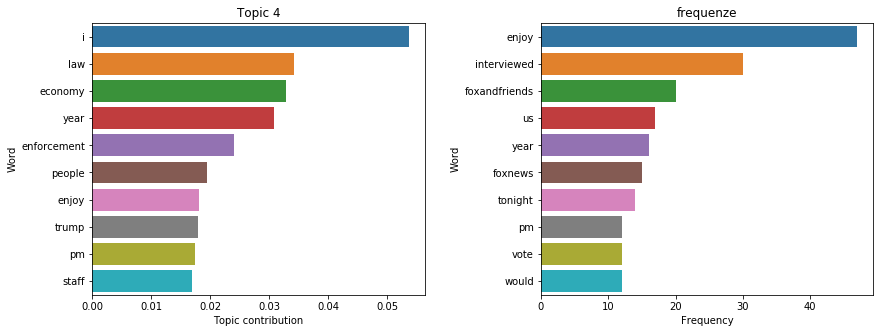

5
NUMBER OF ELEMENTS FOR THIS TOPIC 427
Corpus length in words: 1463


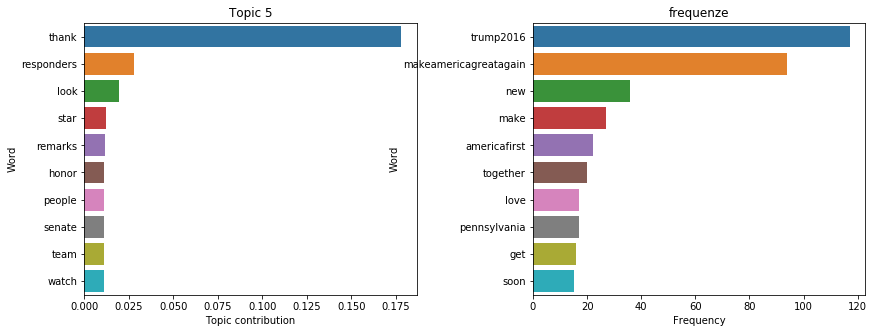

6
NUMBER OF ELEMENTS FOR THIS TOPIC 166
Corpus length in words: 986


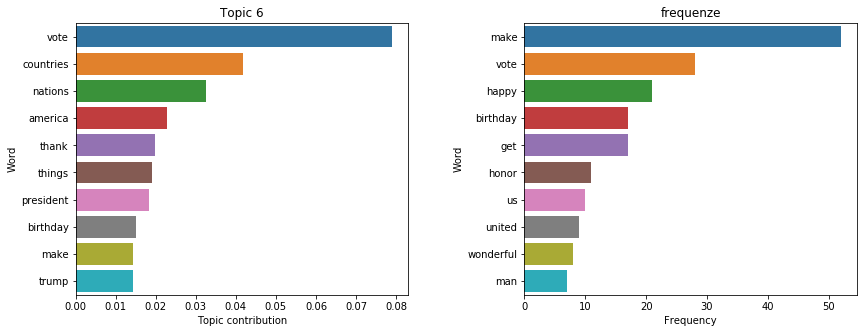

7
NUMBER OF ELEMENTS FOR THIS TOPIC 156
Corpus length in words: 1309


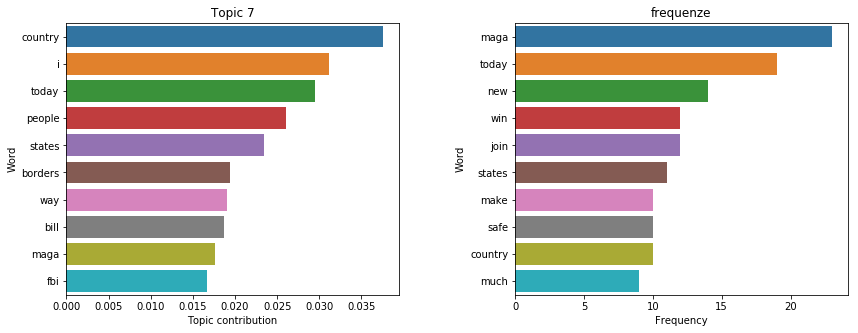

8
NUMBER OF ELEMENTS FOR THIS TOPIC 116
Corpus length in words: 949


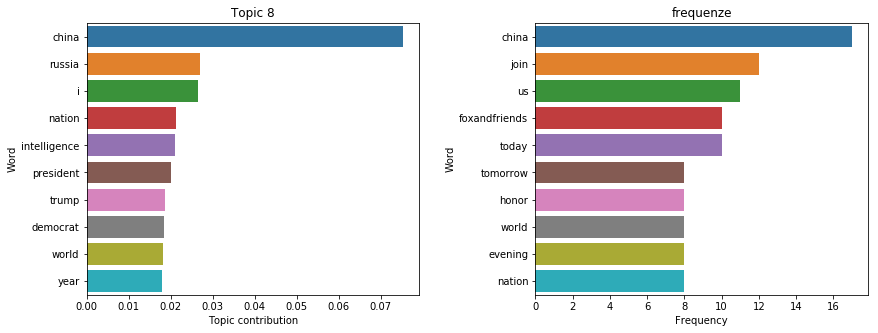

9
NUMBER OF ELEMENTS FOR THIS TOPIC 109
Corpus length in words: 988


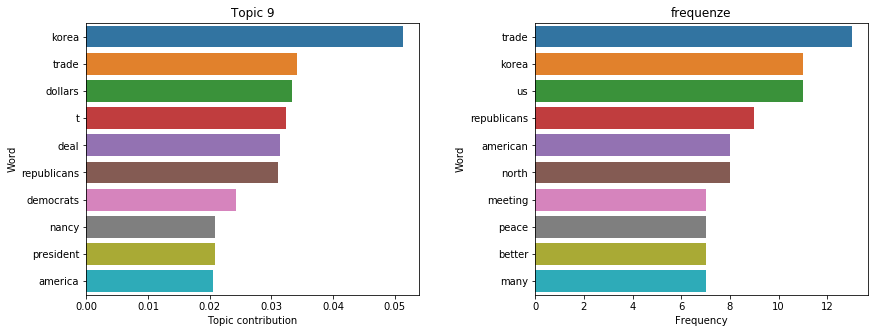

10
NUMBER OF ELEMENTS FOR THIS TOPIC 94
Corpus length in words: 638


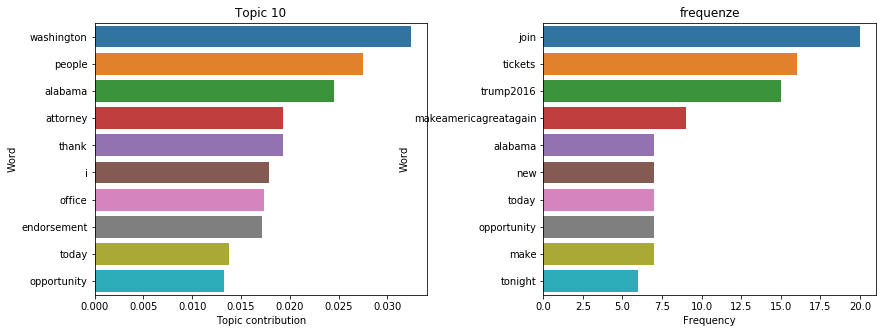

11
NUMBER OF ELEMENTS FOR THIS TOPIC 100
Corpus length in words: 835


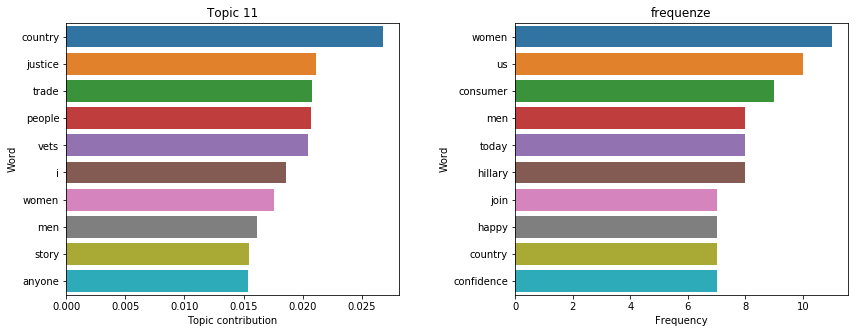

12
NUMBER OF ELEMENTS FOR THIS TOPIC 286
Corpus length in words: 2282


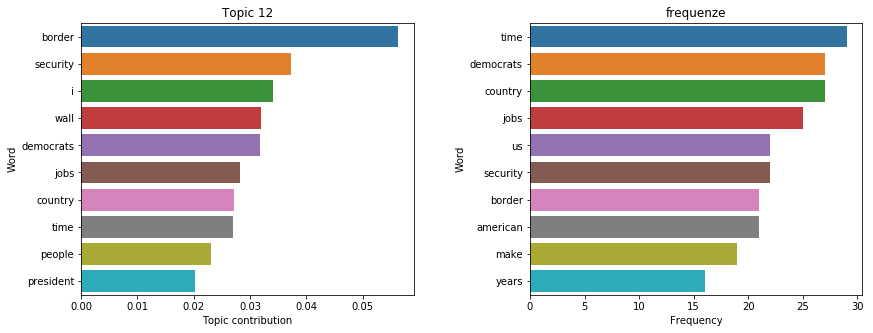

13
NUMBER OF ELEMENTS FOR THIS TOPIC 99
Corpus length in words: 791


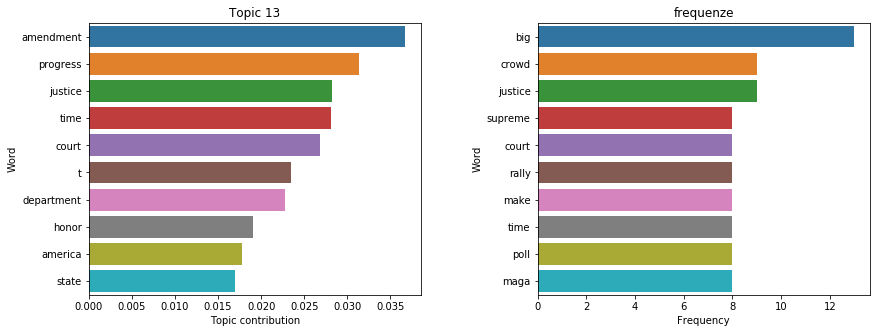

14
NUMBER OF ELEMENTS FOR THIS TOPIC 96
Corpus length in words: 812


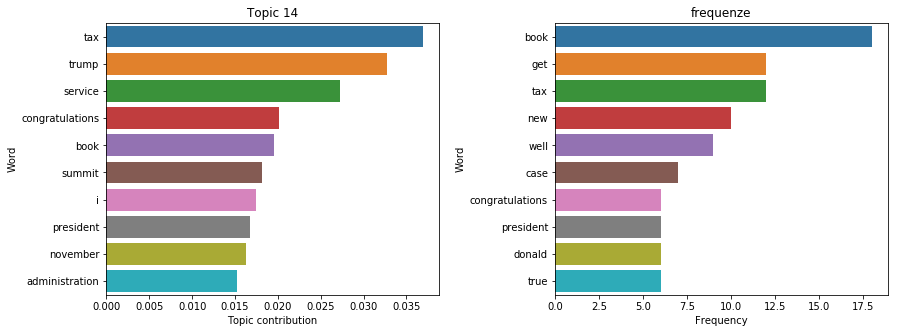

15
NUMBER OF ELEMENTS FOR THIS TOPIC 68
Corpus length in words: 484


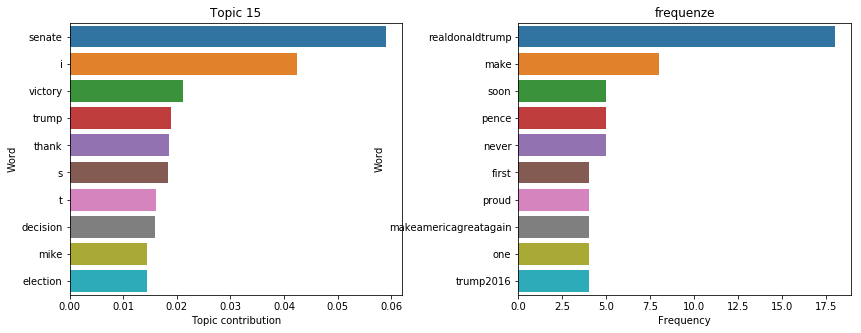

16
NUMBER OF ELEMENTS FOR THIS TOPIC 127
Corpus length in words: 849


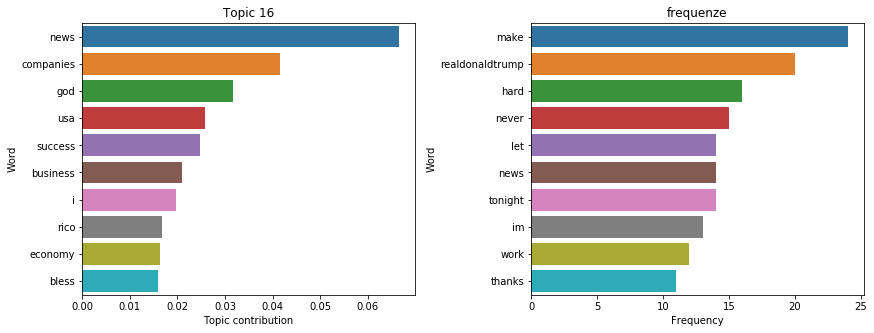

In [36]:
analyzeRes(post,topicsPost,1)

# OBAMA

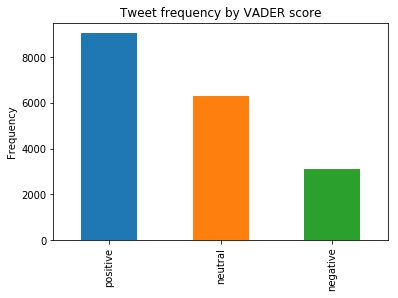

In [46]:
obama = pd.read_csv("obamaprocessed.csv")
obama = applyVader1(obama)

plt.title("Tweet frequency by VADER score")
plt.ylabel("Frequency")
obama["vaderScoreBinned"].value_counts().plot(kind="bar")

10064


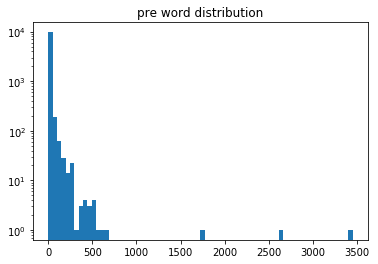

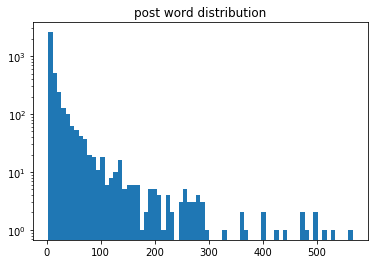

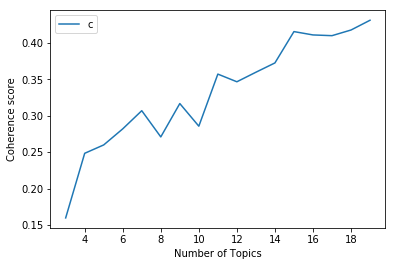

19


In [31]:
obama = obama[obama["vaderScoreBinned"] == "positive"]
nTopicsOba, common_dictOba, corpusOba = processAndFindTopics(obama)

9055 9055


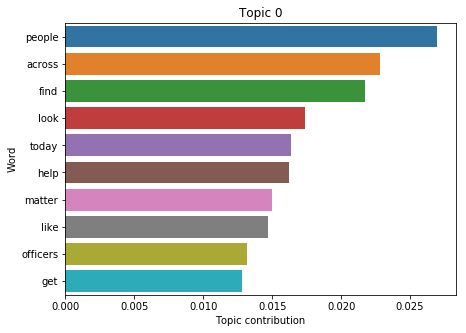

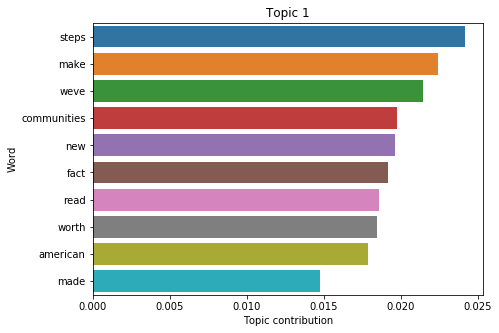

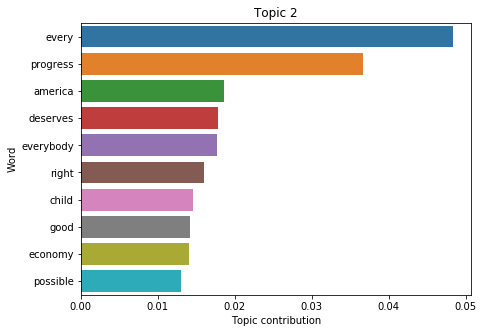

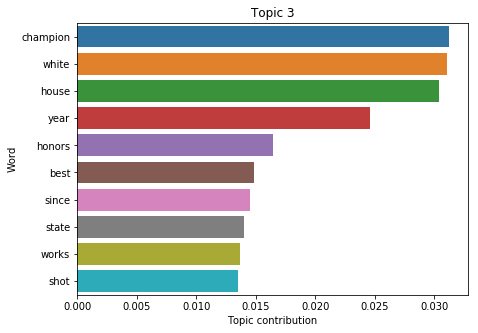

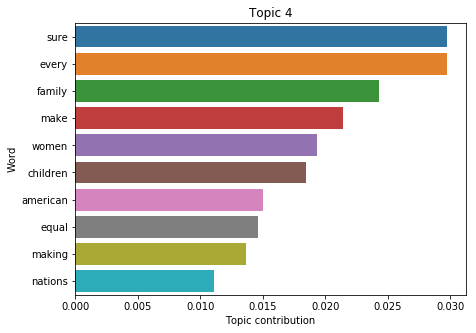

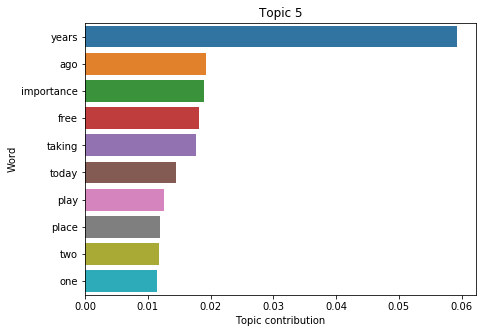

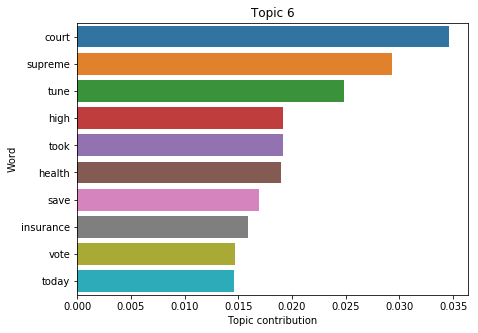

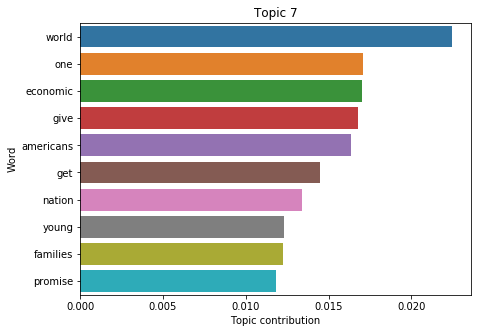

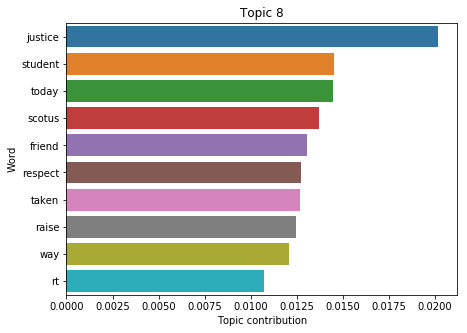

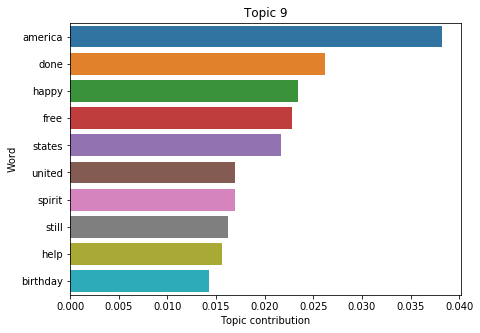

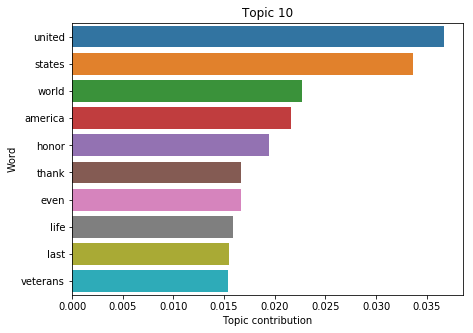

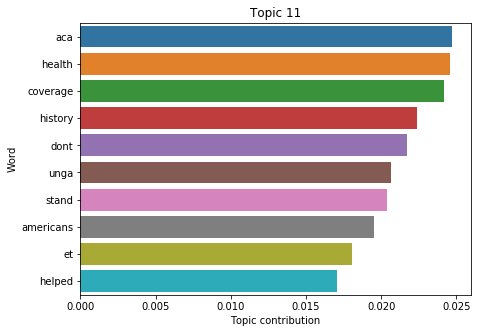

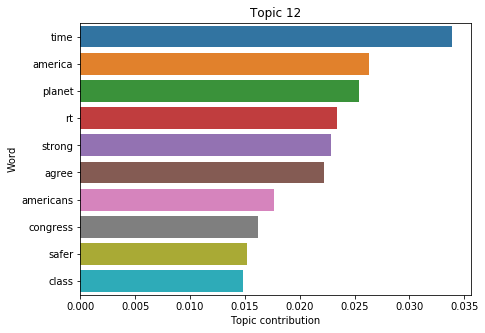

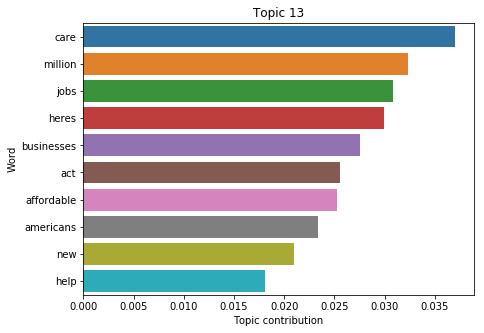

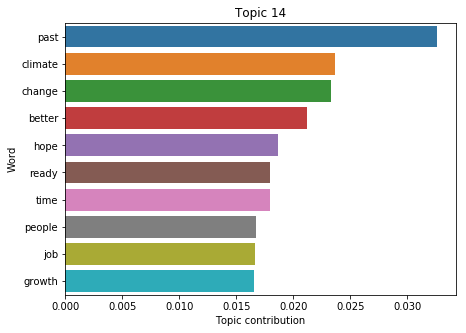

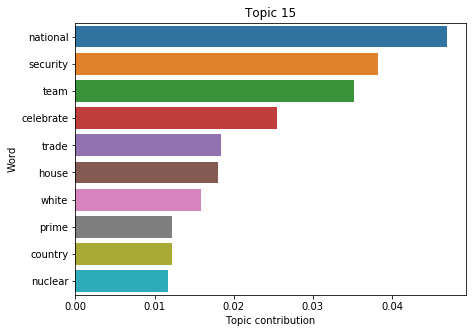

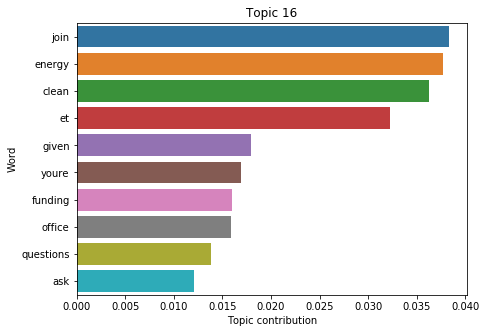

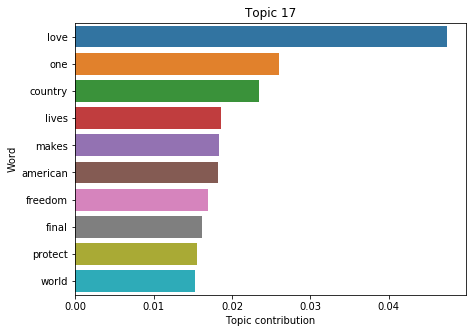

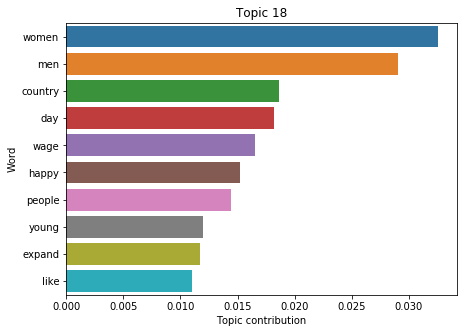

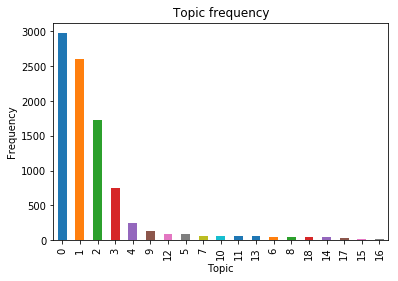

In [32]:
topics = applyLda(obama,nTopicsOba,corpusOba,common_dictOba)

In [48]:
analyzeRes(obama,topics,1)

KeyError: 'topic'